# Deep Neural Network

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import os
import pickle
from sklearn.utils import shuffle
import math

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


To build our neural network, we'll be implementing several "helper functions." These helper functions will be used in a implementation aftwards.

- Initialize the parameters for an $L$-layer neural network
- Implement the forward propagation module (shown in purple in the figure below)
     - Complete the LINEAR part of a layer's forward propagation step (resulting in $Z^{[l]}$).
     - The ACTIVATION function
     - Combine the previous two steps into a new [LINEAR->ACTIVATION] forward function.
     - Stack the [LINEAR->RELU] forward function L-1 time (for layers 1 through L-1) and add a [LINEAR->SIGMOID] at the end (for the final layer $L$). This gives we a new L_model_forward function.
- Compute the loss
- Implement the backward propagation module (denoted in red in the figure below)
    - Complete the LINEAR part of a layer's backward propagation step
    - The gradient of the ACTIVATION function
    - Combine the previous two steps into a new [LINEAR->ACTIVATION] backward function
    - Stack [LINEAR->RELU] backward L-1 times and add [LINEAR->SIGMOID] backward in a new L_model_backward function
- Finally, update the parameters

<center><img src="images/final outline.png" style="width:800px;height:500px;"></center>
<caption><center><b>Figure 1</b></center></caption><br>

For every forward function, there is a corresponding backward function. This is why at every step from the forward module we will be storing some values in a cache. These cached values are useful for computing gradients. In the backpropagation module, the cache is used to calculate the gradients.

## Initialization

We will use [np.random.randn](https://numpy.org/doc/stable/reference/random/generated/numpy.random.randn.html) and [np.zeros](https://numpy.org/doc/stable/reference/generated/numpy.zeros.html).

The "He Initialization" is named for the first author of He et al., 2015. (If you have heard of "Xavier initialization", this is similar except Xavier initialization uses a scaling factor for the weights $W^{[l]}$ of `sqrt(1./layers_dims[l-1])` where He initialization would use `sqrt(2./layers_dims[l-1])`.)

In [63]:
def initialize_parameters(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """
    
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims) # number of layers in the network
    
    for l in range(1, L):
        # Dividing by sqrt of layer so ...
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l - 1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))
    
    return parameters

### L-layer Neural Network

The initialization for a deeper L-layer neural network is complicated because there are many weight matrices and bias vectors. The dimensions should match between each layer. The number of units in layer $l$ is $n^{[l]}$ is . For example, if the size of your input $X$ is $(3072, 3000)$ (with $m=3000$ examples) then:

<table style="width:100%">
    <tr>
        <td>  </td> 
        <td> <b>Shape of W</b> </td> 
        <td> <b>Shape of b</b>  </td> 
        <td> <b>Activation</b> </td>
        <td> <b>Shape of Activation</b> </td> 
    <tr>
    <tr>
        <td> <b>Layer 1</b> </td> 
        <td> $(n^{[1]},3072)$ </td> 
        <td> $(n^{[1]},1)$ </td> 
        <td> $Z^{[1]} = W^{[1]}  X + b^{[1]} $ </td> 
        <td> $(n^{[1]},3000)$ </td> 
    <tr>
    <tr>
        <td> <b>Layer 2</b> </td> 
        <td> $(n^{[2]}, n^{[1]})$  </td> 
        <td> $(n^{[2]},1)$ </td> 
        <td>$Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}$ </td> 
        <td> $(n^{[2]}, 3000)$ </td> 
    <tr>
       <tr>
        <td> $\vdots$ </td> 
        <td> $\vdots$  </td> 
        <td> $\vdots$  </td> 
        <td> $\vdots$</td> 
        <td> $\vdots$  </td> 
    <tr>  
   <tr>
       <td> <b>Layer L-1</b> </td> 
        <td> $(n^{[L-1]}, n^{[L-2]})$ </td> 
        <td> $(n^{[L-1]}, 1)$  </td> 
        <td>$Z^{[L-1]} =  W^{[L-1]} A^{[L-2]} + b^{[L-1]}$ </td> 
        <td> $(n^{[L-1]}, 3000)$ </td> 
   <tr>
   <tr>
       <td> <b>Layer L</b> </td> 
        <td> $(n^{[L]}, n^{[L-1]})$ </td> 
        <td> $(n^{[L]}, 1)$ </td>
        <td> $Z^{[L]} =  W^{[L]} A^{[L-1]} + b^{[L]}$</td>
        <td> $(n^{[L]}, 3000)$  </td> 
    <tr>
</table>

When $W X + b$ is computed in python, it carries out broadcasting. For example, if: 

$$ W = \begin{bmatrix}
    w_{00}  & w_{01} & w_{02} \\
    w_{10}  & w_{11} & w_{12} \\
    w_{20}  & w_{21} & w_{22} 
\end{bmatrix}\;\;\; X = \begin{bmatrix}
    x_{00}  & x_{01} & x_{02} \\
    x_{10}  & x_{11} & x_{12} \\
    x_{20}  & x_{21} & x_{22} 
\end{bmatrix} \;\;\; b =\begin{bmatrix}
    b_0  \\
    b_1  \\
    b_2
\end{bmatrix}\tag{1}$$

Then $WX + b$ will be:

$$ WX + b = \begin{bmatrix}
    (w_{00}x_{00} + w_{01}x_{10} + w_{02}x_{20}) + b_0 & (w_{00}x_{01} + w_{01}x_{11} + w_{02}x_{21}) + b_0 & \cdots \\
    (w_{10}x_{00} + w_{11}x_{10} + w_{12}x_{20}) + b_1 & (w_{10}x_{01} + w_{11}x_{11} + w_{12}x_{21}) + b_1 & \cdots \\
    (w_{20}x_{00} + w_{21}x_{10} + w_{22}x_{20}) + b_2 &  (w_{20}x_{01} + w_{21}x_{11} + w_{22}x_{21}) + b_2 & \cdots
\end{bmatrix}\tag{2}  $$


## Forward Propagation Module

### Linear Forward 

We'll be implementing three functions in this order:

- LINEAR
- LINEAR -> ACTIVATION where ACTIVATION will be either ReLU or Sigmoid. 
- [LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID (whole model)

The linear forward module (vectorized over all the examples) computes the following equations:

$$Z^{[l]} = W^{[l]}A^{[l-1]} +b^{[l]}\tag{3}$$

where $A^{[0]} = X$. 

In [64]:
def linear_forward(A, W, b):
    """
    Implement the linear part of a layer's forward propagation.

    Arguments:
    A -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)

    Returns:
    Z -- the input of the activation function, also called pre-activation parameter 
    cache -- a python tuple containing "A", "W" and "b"; stored for computing the backward pass efficiently
    """
    
    Z = np.dot(W, A) + b
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    
    cache = (A, W, b)
    
    return Z, cache

### Linear-Activation Forward

We will use two activation functions:

- **Sigmoid**: $\sigma(Z) = \sigma(W A + b) = \frac{1}{ 1 + e^{-(W A + b)}}$. The `sigmoid` function is going to  returns **two** items: the activation value "`a`" and a "`cache`" that contains "`Z`" (it's what we will feed in to the corresponding backward function). To use it we could just call: 
``` python
A, activation_cache = sigmoid(Z)
```

- **ReLU**: The mathematical formula for ReLu is $A = RELU(Z) = max(0, Z)$. This function will return **two** items: the activation value "`A`" and a "`cache`" that contains "`Z`" (it's what we'll feed in to the corresponding backward function). To use it we could just call:
``` python
A, activation_cache = relu(Z)
```

For added convenience, we're going to group two functions (Linear and Activation) into one function (LINEAR->ACTIVATION). Hence, we'll implement a function that does the LINEAR forward step, followed by an ACTIVATION forward step.


In [65]:
def sigmoid(Z):
    """
    Implement the sigmoid activation function.

    Arguments:
    Z -- numpy array of any shape

    Returns:
    A -- output of sigmoid(z), same shape as Z
    cache -- returns Z as well, useful during backpropagation
    """
    
    A = 1 / (1 + np.exp(-Z))
    cache = Z
    
    return A, cache


def relu(Z):
    """
    Implement the RELU function.

    Arguments:
    Z -- Output of the linear layer, of any shape

    Returns:
    A -- Post-activation parameter, of the same shape as Z
    cache -- a python dictionary containing "A" ; stored for computing the backward pass efficiently
    """
    
    A = np.maximum(0, Z)
    
    assert(A.shape == Z.shape)
    
    cache = Z 
    return A, cache



def linear_activation_forward(A_prev, W, b, activation):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer

    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    A -- the output of the activation function, also called the post-activation value 
    cache -- a python tuple containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently
    """
    
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
        
    else:
        print("\033[91mError! Please make sure you have passed the value correctly in the \"activation\" parameter")
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)
    
    return A, cache

### L-Layer Model 

For even *more* convenience when implementing the $L$-layer Neural Net, we will need a function that replicates the previous one (`linear_activation_forward` with RELU) $L-1$ times, then follows that with one `linear_activation_forward` with SIGMOID.

<center><img src="images/model_architecture_kiank.png" style="width:600px;height:300px;"></center>
<caption><center> <b>Figure 2</b> : *[LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID* model</center></caption><br>

###  L_model_forward

In the code below, the variable `AL` will denote $A^{[L]} = \sigma(Z^{[L]}) = \sigma(W^{[L]} A^{[L-1]} + b^{[L]})$. (This is sometimes also called `Yhat`, i.e., this is $\hat{Y}$.) 

In [66]:
def L_model_forward(X, parameters):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()
    
    Returns:
    AL -- activation value from the output (last) layer
    caches -- list of caches containing:
                every cache of linear_activation_forward() (there are L of them, indexed from 0 to L-1)
    """

    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    
    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    # The for loop starts at 1 because layer 0 is the input
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev,
                                             parameters['W' + str(l)],
                                             parameters['b' + str(l)],
                                             'relu')
        caches.append(cache)
    
    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
    AL, cache = linear_activation_forward(A,
                                          parameters['W' + str(L)],
                                          parameters['b' + str(L)],
                                          'sigmoid')
    caches.append(cache)
    
    assert(AL.shape == (1,X.shape[1]))

    return AL, caches

## Cost Function

In order to check whether the model is actually learning, we need to compute the cost using the following formula:

$$-\frac{1}{m} \sum\limits_{i = 1}^{m} (y^{(i)}\log\left(a^{[L] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right)) \tag{4}$$


In [67]:
def compute_cost(AL, Y):
    """
    Implement the cost function.

    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost
    """
    
    m = Y.shape[1]

    # Compute loss from aL and y.
    cost = (1./m) * (-np.dot(Y,np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T))
    
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    assert(cost.shape == ())
    
    return cost

## Backward Propagation Module

Just as done on forward propagation, we will be implementing helper functions for backpropagation. This step is used to calculate the gradient of the loss function with respect to the parameters. 

**Reminder**: 
<center><img src="images/backprop_kiank.png" style="width:650px;height:250px;"></center>
<caption><center><font color='purple'><b>Figure 3</b>: Forward and Backward propagation for LINEAR->RELU->LINEAR->SIGMOID <br> <i>The purple blocks represent the forward propagation, and the red blocks represent the backward propagation.</font></center></caption>


The chain rule of calculus can be used to derive the derivative of the loss $\mathcal{L}$ with respect to $z^{[1]}$ in a 2-layer network as follows

$$\frac{d \mathcal{L}(a^{[2]},y)}{{dz^{[1]}}} = \frac{d\mathcal{L}(a^{[2]},y)}{{da^{[2]}}}\frac{{da^{[2]}}}{{dz^{[2]}}}\frac{{dz^{[2]}}}{{da^{[1]}}}\frac{{da^{[1]}}}{{dz^{[1]}}} \tag{5} $$

In order to calculate the gradient $dW^{[1]} = \frac{\partial L}{\partial W^{[1]}}$, use the previous chain rule and we do $dW^{[1]} = dz^{[1]} \times \frac{\partial z^{[1]} }{\partial W^{[1]}}$. During backpropagation, at each step we multiply our current gradient by the gradient corresponding to the specific layer to get the gradient we wanted.

Equivalently, in order to calculate the gradient $db^{[1]} = \frac{\partial L}{\partial b^{[1]}}$, we use the previous chain rule and $db^{[1]} = dz^{[1]} \times \frac{\partial z^{[1]} }{\partial b^{[1]}}$.

Now, similarly to forward propagation, we're going to build the backward propagation in three steps:
1. LINEAR backward
2. LINEAR -> ACTIVATION backward where ACTIVATION computes the derivative of either the ReLU or sigmoid activation
3. [LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID backward (whole model)

### Linear Backward

For layer $l$, the linear part is: $Z^{[l]} = W^{[l]} A^{[l-1]} + b^{[l]}$ (followed by an activation).

Suppose we have already calculated the derivative $dZ^{[l]} = \frac{\partial \mathcal{L} }{\partial Z^{[l]}}$. We want to get $(dW^{[l]}, db^{[l]}, dA^{[l-1]})$.

<center><img src="images/linearback_kiank.png" style="width:250px;height:300px;"></center>
<caption><center><font color='purple'><b>Figure 4</b></font></center></caption>

The three outputs $(dW^{[l]}, db^{[l]}, dA^{[l-1]})$ are computed using the input $dZ^{[l]}$.

Here are the formulas used:
$$ dW^{[l]} = \frac{\partial \mathcal{J} }{\partial W^{[l]}} = \frac{1}{m} dZ^{[l]} A^{[l-1] T} \tag{6}$$
$$ db^{[l]} = \frac{\partial \mathcal{J} }{\partial b^{[l]}} = \frac{1}{m} \sum_{i = 1}^{m} dZ^{[l](i)}\tag{7}$$
$$ dA^{[l-1]} = \frac{\partial \mathcal{L} }{\partial A^{[l-1]}} = W^{[l] T} dZ^{[l]} \tag{8}$$


$A^{[l-1] T}$ is the transpose of $A^{[l-1]}$. 

In [68]:
def linear_backward(dZ, cache):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    
    A_prev, W, b = cache
    m = A_prev.shape[1]
    
    dA_prev = np.dot(W.T, dZ)
    dW = 1/m * np.dot(dZ, A_prev.T)
    db = 1/m * np.sum(dZ, axis=1, keepdims=True)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

In [69]:
def relu_backward(dA, cache):
    """
    Implement the backward propagation for a single RELU unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    
    # When z <= 0, should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ


def sigmoid_backward(dA, cache):
    """
    Implement the backward propagation for a single SIGMOID unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    activation_cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    
    s = 1 / (1 + np.exp(-Z))
    dZ = dA * s * (1 - s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ

### Linear-Activation Backward

We will also need functions with the derivatives with relatiosions to thje activation functions.

If $g(.)$ is the activation function, 
`sigmoid_backward` and `relu_backward` compute $$dZ^{[l]} = dA^{[l]} * g'(Z^{[l]}). \tag{9}$$  


- **`sigmoid_backward`**:

$$
dZ^{[l]} = \begin{cases}
dA^{[l]}, & \text{if } Z^{[l]} > 0 \\
0, & \text{if } Z^{[l]} \leq 0
\end{cases}
\tag{10}
$$

- **`relu_backward`**:

$$
dZ^{[l]} = dA^{[l]} \cdot \sigma(Z^{[l]}) \cdot (1 - \sigma(Z^{[l]}))
\tag{11}
$$

In [70]:
def linear_activation_backward(dA, cache, activation):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.
    
    Arguments:
    dA -- post-activation gradient for current layer l 
    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

### L-Model Backward 

Finally implementing the backward function for the whole network.

At each iteration, the `L_model_forward` function stores a cache which contains (X, W, b, and z) that is going to be used in the back propagation module to compute the gradients. The `L_model_backward` function iterate through all the hidden layers backward, starting from layer $L$. On each step, the cached values are used for layer $l$ to backpropagate through layer $l$. Figure 5 below shows the backward pass. 


<center><img src="images/mn_backward.png" style="width:450px;height:300px;"></center>
<caption><center><font color='purple'><b>Figure 5</b>: Backward pass</font></center></caption>

**Initializing backpropagation**:

Knowing that $A^{[L]} = \sigma(Z^{[L]})$, to backpropagate through this network, we need to compute `dAL` $= \frac{\partial \mathcal{L}}{\partial A^{[L]}}$.

To do so, we use this formula (derived using calculus):
```python
dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL)) # derivative of cost with respect to AL
```

Implementation of backpropagation for the *[LINEAR->RELU] $\times$ (L-1) -> LINEAR -> SIGMOID* model.

In [71]:
def L_model_backward(AL, Y, caches):
    """
    Implementa a passagem para trás para a rede [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID
    
    Argumentos:
    AL -- ativação pós-ativa, saída da passagem para frente (L_model_forward)
    Y -- vetor de verdadeiros "rótulos" (0 se não é pizza, 1 se é pizza)
    caches -- lista de caches contendo:
                cada cache do linear_activation_forward() com "relu" (há L-1, indexado de 0 a L-2)
                o cache do linear_activation_forward() com "sigmoid" (há 1, indexado L-1)
    
    Retorna:
    grads -- dicionário com os gradientes com relação a cada parâmetro, ativação e pré-ativação variável
    """
    grads = {}
    L = len(caches)  # número de camadas
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)  # Assegure-se de que Y tenha o mesmo formato que AL
    
    # Inicialize a retropropagação
    dAL = -(np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    # Camada L: dAL -> SIGMOID -> LINEAR gradients.
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation="sigmoid")
    
    # Loop da camada L-1 até a camada 0
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, activation="relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads


### Update Parameters

To update the parameters of the model we use gradient descent: 

$$ W^{[l]} = W^{[l]} - \alpha \text{ } dW^{[l]} \tag{12}$$
$$ b^{[l]} = b^{[l]} - \alpha \text{ } db^{[l]} \tag{13}$$

where $\alpha$ is the learning rate. 

After computing the updated parameters, store them in the parameters dictionary. 

In [72]:
def update_parameters_with_gd(params, grads, learning_rate):
    """
    Update parameters using gradient descent
    
    Arguments:
    params -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of L_model_backward
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    """
    
    parameters = copy.deepcopy(params)
    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    for l in range(L):
        parameters["W" + str(l+1)] -= learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] -= learning_rate * grads["db" + str(l+1)]
    
    return parameters

# Deep Neural Network for image classification

## Load and Process the Dataset

We'll be using a [CIFAR-10](https://paperswithcode.com/dataset/cifar-10) dataset.

The CIFAR-10 dataset (Canadian Institute for Advanced Research, 10 classes) is a subset of the Tiny Images dataset and consists of 60000 32x32 color images. The images are labelled with one of 10 mutually exclusive classes: airplane, automobile (but not truck or pickup truck), bird, cat, deer, dog, frog, horse, ship, and truck (but not pickup truck). There are 6000 images per class with 5000 training and 1000 testing images per class.

In our case, we will do a binary classification between cat (class 1) images and the other classes (class 0).

In [73]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Path to the CIFAR-10 dataset
cifar10_path = 'datasets//cifar-10-batches-py/'

# Load all training batches
train_data = []
train_labels = []
for i in range(1, 6):
    batch = unpickle(os.path.join(cifar10_path, f'data_batch_{i}'))
    train_data.append(batch[b'data'])
    train_labels.append(batch[b'labels'])

train_data = np.concatenate(train_data)
train_labels = np.concatenate(train_labels)

# Load test batch
test_batch = unpickle(os.path.join(cifar10_path, 'test_batch'))
test_data = test_batch[b'data']
test_labels = np.array(test_batch[b'labels'])

# Load label names
meta = unpickle(os.path.join(cifar10_path, 'batches.meta'))
label_names = meta[b'label_names']

# Convert byte strings to normal strings
label_names = [label.decode('utf-8') for label in label_names]


In [74]:
# Define the label for the "cat" class
cat_label = label_names.index('cat')

# Separate cat images from other images in the training set
train_cat_indices = np.where(train_labels == cat_label)[0]
train_other_indices = np.where(train_labels != cat_label)[0]

train_cat_data = train_data[train_cat_indices]
train_other_data = train_data[train_other_indices]

train_cat_labels = np.ones(train_cat_indices.shape[0])  # Label 1 for cats
train_other_labels = np.zeros(train_other_indices.shape[0])  # Label 0 for other classes

# Repeat for the test set
test_cat_indices = np.where(test_labels == cat_label)[0]
test_other_indices = np.where(test_labels != cat_label)[0]

test_cat_data = test_data[test_cat_indices]
test_other_data = test_data[test_other_indices]

test_cat_labels = np.ones(test_cat_indices.shape[0])  # Label 1 for cats
test_other_labels = np.zeros(test_other_indices.shape[0])  # Label 0 for other classes

classes = [
    'Other',
    'Cat'
    ]

We should choose how many training examples we will use to feed the model. This can be adjusted so to improve accuracy or reduce amount of time to train.

In [75]:
num_train_exem = 3000
train_class_examples = int(num_train_exem / 2)
test_class_examples = int(num_train_exem / 10)

In [76]:
train_cat_data, train_cat_labels = shuffle(train_cat_data, train_cat_labels, random_state=0)
train_other_data, train_other_labels = shuffle(train_other_data, train_other_labels, random_state=0)
test_cat_data, test_cat_labels = shuffle(test_cat_data, test_cat_labels, random_state=0)
test_other_data, test_other_labels = shuffle(test_other_data, test_other_labels, random_state=0)

train_data = np.vstack((train_cat_data[:train_class_examples], train_other_data[:train_class_examples]))
train_labels = np.concatenate((train_cat_labels[:train_class_examples], train_other_labels[:train_class_examples]))

test_data = np.vstack((test_cat_data[:test_class_examples], test_other_data[:test_class_examples]))
test_labels = np.concatenate((test_cat_labels[:test_class_examples], test_other_labels[:test_class_examples]))

train_data, train_labels = shuffle(train_data, train_labels, random_state=0)
test_data, test_labels = shuffle(test_data, test_labels, random_state=0)


Cat Images:


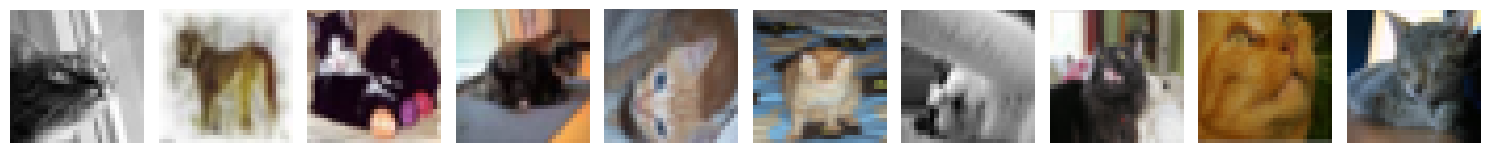

Other Images:


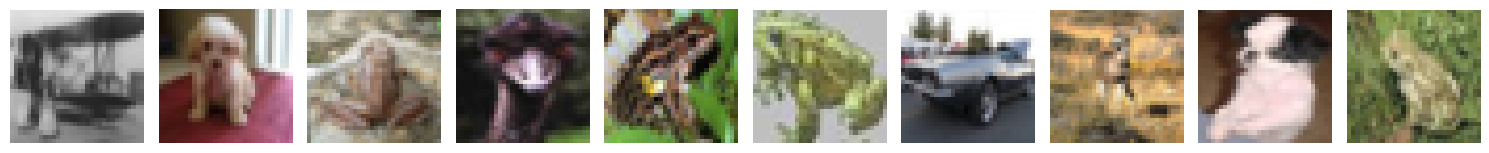

In [77]:
def plot_image(data, indices):
    num_images = len(indices)
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))

    for i, idx in enumerate(indices):
        img = data[idx].reshape(3, 32, 32).transpose(1, 2, 0)
        axes[i].imshow(img)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()


def plot_cat_and_other_images(cat_data, other_data, num_images):
    # Plot cat images
    print("Cat Images:")
    plot_image(cat_data, range(num_images))

    # Plot other images
    print("Other Images:")
    plot_image(other_data, range(num_images))


plot_cat_and_other_images(train_cat_data, train_other_data, num_images=10)


In [78]:
m_train = train_data.shape[0]
num_px = train_data.shape[1]
m_test = test_data.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_data shape: " + str(train_data.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_data shape: " + str(test_data.shape))
print ("test_labels shape: " + str(test_labels.shape))

Number of training examples: 3000
Number of testing examples: 600
Each image is of size: (3072, 3072, 3)
train_data shape: (3000, 3072)
train_labels shape: (3000,)
test_data shape: (600, 3072)
test_labels shape: (600,)


We will reshape and standardize the images before feeding them to the network.

In [79]:
# Reshape the training and test examples 
train_x_flatten = train_data.T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_data.T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (3072, 3000)
test_x's shape: (3072, 600)


**Note**:
$3.072$ equals $32 \times 32 \times 3$, which is the size of one reshaped image vector.

## Model Architecture

You're going to build two different models:

- A 2-layer neural network
- An L-layer deep neural network

We'll compare the performance of these models, and try out some different values for $L$. 

### 2-layer Neural Network

The model can be summarized as: INPUT -> LINEAR -> RELU -> LINEAR -> SIGMOID -> OUTPUT.

<u><b>Detailed Architecture</b></u>:
- The input is a (32,32,3) image which is flattened to a vector of size $(12288,1)$. 
- The corresponding vector: $[x_0,x_1,...,x_{3072}]^T$ is then multiplied by the weight matrix $W^{[1]}$ of size $(n^{[1]}, 12288)$.
- Then, add a bias term and take its relu to get the following vector: $[a_0^{[1]}, a_1^{[1]},..., a_{n^{[1]}-1}^{[1]}]^T$.
- Multiply the resulting vector by $W^{[2]}$ and add the intercept (bias). 
- Finally, take the sigmoid of the result. If it's greater than 0.5, classify it as a cat.


### L-layer Deep Neural Network

It's pretty difficult to represent an L-layer deep neural network using the above representation. However, here is a simplified network representation:

The model can be summarized as: [LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID

<u><b>Detailed Architecture</b></u>:
- The input is a (32,32,3) image which is flattened to a vector of size (3072,1).
- The corresponding vector: $[x_0,x_1,...,x_{3072}]^T$ is then multiplied by the weight matrix $W^{[1]}$ and then add the intercept $b^{[1]}$. The result is called the linear unit.
- Next, take the relu of the linear unit. This process could be repeated several times for each $(W^{[l]}, b^{[l]})$ depending on the model architecture.
- Finally, take the sigmoid of the final linear unit. If it is greater than 0.5, classify it as a cat.



### General Methodology

The Deep Learning methodology to build is as follows:

1. Initialize parameters / Define hyperparameters
2. Loop for num_iterations:
    a. Forward propagation
    b. Compute cost function
    c. Backward propagation
    d. Update parameters (using parameters, and grads from backprop) 
3. Use trained parameters to predict labels

## Two-layer Neural Network

In [80]:
### CONSTANTS DEFINING THE MODEL ####
n_x = train_x.shape[0]     # num_px * num_px * 3
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)
lr = 0.01

In [81]:
def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Implements a two-layer neural network: LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (n_x, number of examples)
    Y -- true "label" vector (containing 1 if cat, 0 if non-cat), of shape (1, number of examples)
    layers_dims -- dimensions of the layers (n_x, n_h, n_y)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- If set to True, this will print the cost every 100 iterations 
    
    Returns:
    parameters -- a dictionary containing W1, W2, b1, and b2
    """
    
    np.random.seed(1)
    grads = {}
    costs = []                              # to keep track of the cost
    m = X.shape[1]                           # number of examples
    (n_x, n_h, n_y) = layers_dims
    
    # Initialize parameters dictionary, by calling one of the functions you'd previously implemented
    parameters = initialize_parameters([n_x, n_h, n_y])
    
    # Get W1, b1, W2 and b2 from the dictionary parameters.
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Reshape Y if necessary
    if Y.ndim == 1:
        Y = Y.reshape(1, -1)
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):
        
        # Forward propagation: LINEAR -> RELU -> LINEAR -> SIGMOID. Inputs: "X, W1, b1, W2, b2". Output: "A1, cache1, A2, cache2".
        A1, cache1 = linear_activation_forward(X, W1, b1, "relu")
        A2, cache2 = linear_activation_forward(A1, W2, b2, "sigmoid")
        cost = compute_cost(A2, Y)
        
        # Initializing backward propagation
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
        # Backward propagation. Inputs: "dA2, cache2, cache1". Outputs: "dA1, dW2, db2; also dA0 (not used), dW1, db1".
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, "sigmoid")
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, "relu")
        
        # Set grads['dWl'] to dW1, grads['db1'] to db1, grads['dW2'] to dW2, grads['db2'] to db2
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        # Update parameters.
        parameters = update_parameters_with_gd(parameters, grads, learning_rate)
        
        # Retrieve W1, b1, W2, b2 from parameters
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        # Print the cost every 100 iterations
        if print_cost and i % 100 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0 or i == num_iterations:
            costs.append(cost)

    return parameters, costs

def plot_costs(costs, learning_rate=0.0075):
    plt.rcParams['figure.figsize'] = (5.0, 4.0)
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

In [82]:
parameters, costs = two_layer_model(train_x,
                                    train_labels,
                                    layers_dims = (n_x, n_h, n_y),
                                    learning_rate = lr,
                                    num_iterations = 4000,
                                    print_cost=True)
plot_costs(costs, learning_rate = lr)

Cost after iteration 0: 0.708916314206992
Cost after iteration 100: 0.6559001349704672


KeyboardInterrupt: 

In [ ]:
def predict(X, y, parameters):
    """
    This function is used to predict the results of a  L-layer neural network.
    
    Arguments:
    X -- data set of examples to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    
    m = X.shape[1]
    p = np.zeros((1,m))
    
    # Forward propagation
    probas, caches = L_model_forward(X, parameters)

    
    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    print("Accuracy: "  + str(round(np.sum((p == y)/m), 4)))
        
    return p

def print_mislabeled_images(classes, X, y, p, num_images=10):
    """
    Plots images where predictions and truth were different.
    X -- dataset
    y -- true labels
    p -- predictions
    """
    mislabeled_indices = np.where(p != y)[1]
    
    plt.rcParams['figure.figsize'] = (20.0, 20.0)  # set default size of plots
    num_images = min(len(mislabeled_indices), num_images)
    
    if num_images > 10:
        num_images = 10
    
    for i in range(num_images):
        index = mislabeled_indices[i]
        
        plt.subplot(1, num_images, i + 1)
        img = X[index].reshape(3, 32, 32).transpose(1, 2, 0)
        plt.imshow(img, interpolation='nearest')
        plt.axis('off')
        plt.title(f"Prediction: {classes[int(p[0][index])]} \n Class: {classes[int(y[index])]}")
    
    plt.tight_layout()
    plt.show()


def print_correctly_labeled_images(classes, X, y, p, num_images=10):
    """
    Plots images where predictions and truth were the same.
    
    Parameters:
    classes -- list of class names
    X -- dataset (images)
    y -- true labels
    p -- predictions
    num_images -- number of images to plot (default is 10)
    """
    correctly_labeled_indices = np.where(p == y)[1] 
    
    plt.rcParams['figure.figsize'] = (20.0, 20.0)  # set default size of plots
    num_images = min(len(correctly_labeled_indices), num_images)
    
    for i in range(num_images):
        index = correctly_labeled_indices[i]
        
        plt.subplot(1, num_images, i + 1)
        img = X[index].reshape(3, 32, 32).transpose(1, 2, 0)
        plt.imshow(img, interpolation='nearest')
        plt.axis('off')
        plt.title(f"Prediction: {classes[int(p[0][index])]} \n Class: {classes[int(y[index])]}")
    
    plt.tight_layout()
    plt.show()

In [ ]:
pred_train = predict(train_x, train_labels, parameters)

Accuracy: 0.7227


In [ ]:
pred_test = predict(test_x, test_labels, parameters)

Accuracy: 0.6883


Misclassified images: 


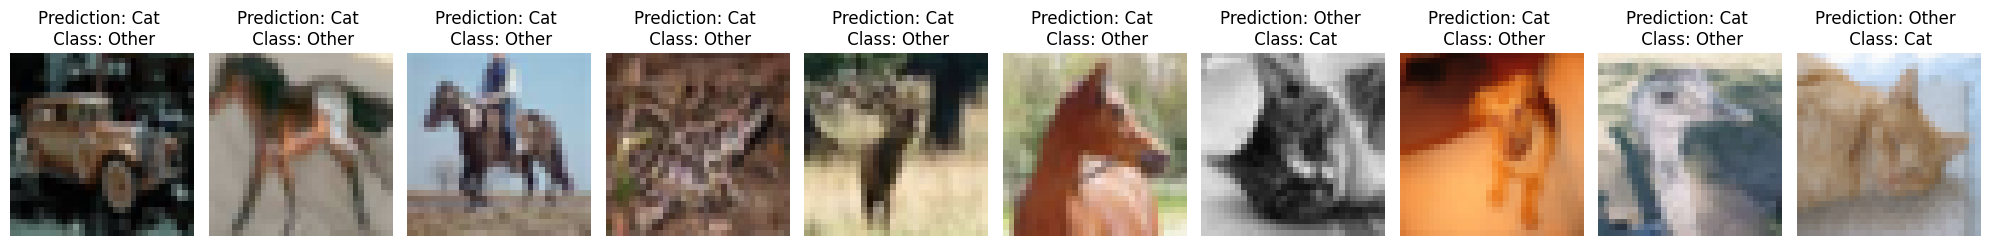

Correctly classified images: 


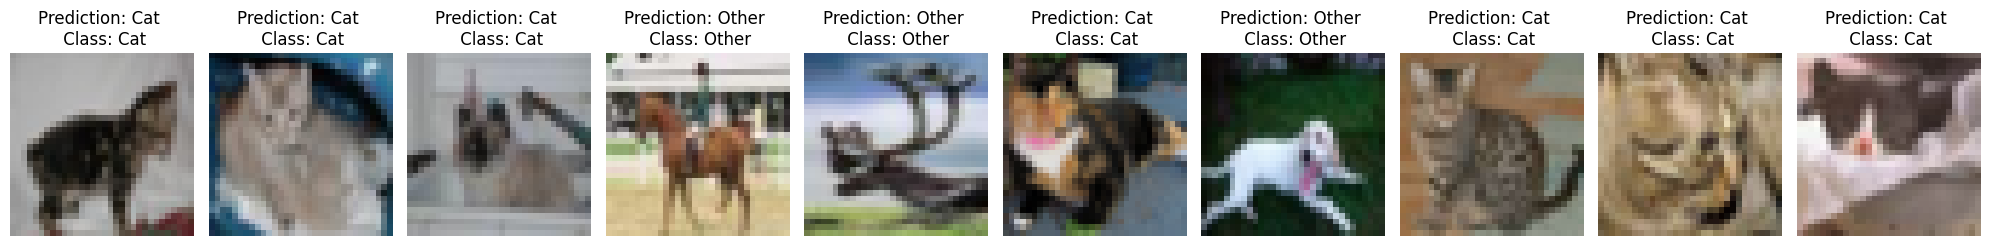

In [ ]:
print("Misclassified images: ")
print_mislabeled_images(classes, test_data, test_labels, pred_test)

print("Correctly classified images: ")
print_correctly_labeled_images(classes, test_data, test_labels, pred_test)

## L-layer Neural Network

In [ ]:
### CONSTANTS ###
layers_dims = [train_x.shape[0], 20, 10, 6, 1]  # 4 layer model

In [ ]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (n_x, number of examples)
    Y -- true "label" vector (containing 1 if cat, 0 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization.
    parameters = initialize_parameters(layers_dims)
    
    # Reshape Y if necessary
    if Y.ndim == 1:
        Y = Y.reshape(1, -1)
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_model_forward(X, parameters)
        
        cost = compute_cost(AL, Y)
        
        # Backward propagation.
        grads = L_model_backward(AL, Y, caches)
        
        # Update parameters.
        parameters = update_parameters_with_gd(parameters, grads, learning_rate)
        
        # Print the cost every 100 iterations
        if print_cost and i % 100 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0 or i == num_iterations:
            costs.append(cost)
    
    return parameters, costs

Cost after iteration 0: 0.6961971460409616
Cost after iteration 100: 0.6575678210881635
Cost after iteration 200: 0.639044716075626
Cost after iteration 300: 0.6266857617143564
Cost after iteration 400: 0.6152218781556457
Cost after iteration 500: 0.6031638195166144
Cost after iteration 600: 0.5918106774240892
Cost after iteration 700: 0.5982378466970794
Cost after iteration 800: 0.5929352171499466
Cost after iteration 900: 0.5881385100349223
Cost after iteration 1000: 0.5807155354768893
Cost after iteration 1100: 0.5775455930937086
Cost after iteration 1200: 0.5723760843641051
Cost after iteration 1300: 0.5681333054059788
Cost after iteration 1400: 0.5620824979892024
Cost after iteration 1500: 0.5555932088352792
Cost after iteration 1600: 0.5507324888962107
Cost after iteration 1700: 0.5489871417135233
Cost after iteration 1800: 0.5400259773794357
Cost after iteration 1900: 0.5367763733599136
Cost after iteration 2000: 0.5342290304041485
Cost after iteration 2100: 0.5271557305697162
C

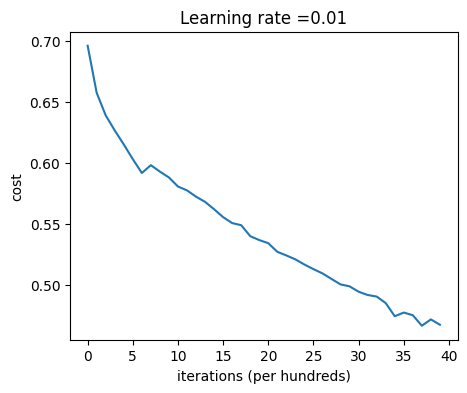

Train
Accuracy: 0.7763
Test
Accuracy: 0.6917


In [ ]:
parameters, costs = L_layer_model(train_x,
                                  train_labels,
                                  layers_dims,
                                  learning_rate = lr,
                                  num_iterations = 4000,
                                  print_cost = True)

plot_costs(costs, learning_rate = lr)

print("Train")
pred_train = predict(train_x, train_labels, parameters)

print("Test")
pred_test = predict(test_x, test_labels, parameters)

Misclassified images: 


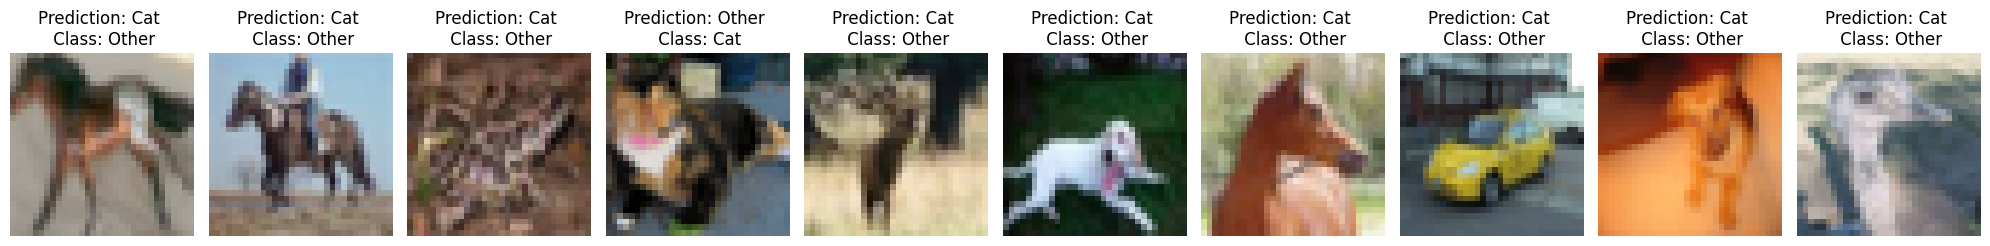

Correctly classified images: 


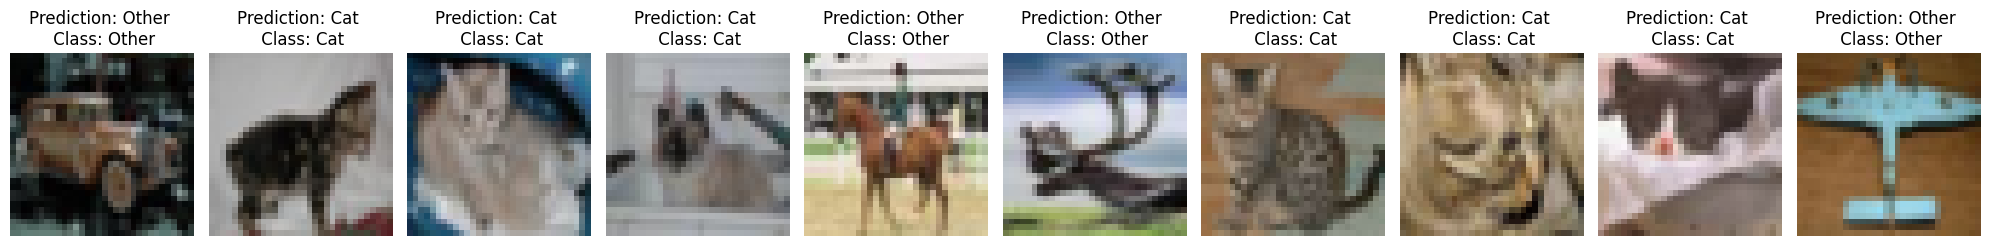

In [ ]:
print("Misclassified images: ")
print_mislabeled_images(classes, test_data, test_labels, pred_test)

print("Correctly classified images: ")
print_correctly_labeled_images(classes, test_data, test_labels, pred_test)

The model is far from perfect, but just for demonstration purposes, it is fine enough.

# Regularization

Deep Learning models have so much flexibility and capacity that **overfitting can be a serious problem**, if the training dataset is not big enough. Sure it does well on the training set, but the learned network **doesn't generalize to new examples** that it has never seen!

**Observations**:
- The value of $\lambda$ is a hyperparameter that you can tune using a dev set.
- L2 regularization makes your decision boundary smoother. If $\lambda$ is too large, it is also possible to "oversmooth", resulting in a model with high bias.

**What is L2-regularization actually doing?**:

L2-regularization relies on the assumption that a model with small weights is simpler than a model with large weights. Thus, by penalizing the square values of the weights in the cost function all the weights tend to be smaller values. In other words, it becomes too costly for the cost to have large weights, leading to a smoother model in which the output changes more slowly as the input changes, reducing overfitting.

<br>
<font color='blue'>

**About L2-regularization:**:
- The cost computation:
    - A regularization term is added to the cost.
- The backpropagation function:
    - There are extra terms in the gradients with respect to weight matrices.
- Weights end up smaller ("weight decay"): 
    - Weights are pushed to smaller values.

## L2 Regularization

The standard way to avoid overfitting is called **L2 regularization**. It consists of appropriately modifying your cost function, from:
$$J = -\frac{1}{m} \sum\limits_{i = 1}^{m} \large{(}\small  y^{(i)}\log\left(a^{[L](i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right) \large{)} \tag{14}$$
To:
$$J_{regularized} = \small \underbrace{-\frac{1}{m} \sum\limits_{i = 1}^{m} \large{(}\small y^{(i)}\log\left(a^{[L](i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right) \large{)} }_\text{cross-entropy cost} + \underbrace{\frac{1}{m} \frac{\lambda}{2} \sum\limits_l\sum\limits_k\sum\limits_j W_{k,j}^{[l]2} }_\text{L2 regularization cost} \tag{15}$$

Let's modify your cost and observe the consequences.

In [ ]:
def compute_cost_with_regularization(A3, Y, parameters, lambd):
    """
    Implement the cost function with L2 regularization. See formula (2) above.
    
    Arguments:
    A3 -- post-activation, output of forward propagation, of shape (output size, number of examples)
    Y -- "true" labels vector, of shape (output size, number of examples)
    parameters -- python dictionary containing parameters of the model
    
    Returns:
    cost - value of the regularized loss function (formula (2))
    """
    m = Y.shape[1]
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    W3 = parameters["W3"]

    cross_entropy_cost = compute_cost(A3, Y) # This gives you the cross-entropy part of the cost
    
    L2_regularization_cost = (lambd / (2 * m)) * (np.sum(np.square(W1)) + np.sum(np.square(W2)) + np.sum(np.square(W3)))
    cost = cross_entropy_cost + L2_regularization_cost
    
    return cost

Because we changed the cost, we will need to change backward propagation as well. All the gradients have to be computed with respect to this new cost to take into account regularization. The changes only concern dW1, dW2 and dW3. For each, you have to add the regularization term's gradient ($\frac{d}{dW} ( \frac{1}{2}\frac{\lambda}{m}  W^2) = \frac{\lambda}{m} W$).

In [ ]:
def L_model_backward_with_regularization(AL, Y, caches, lambd):
    """
    Implementa a retropropagação para toda a rede, adicionando regularização L2.
    
    Argumentos:
    AL -- Saídas da última camada (vetor de previsões)
    Y -- "Verdadeiros" rótulos de vetor
    caches -- Lista de caches contendo:
                cada cache linear_activation_forward("relu") (há L-1 deles, indexados de 0 a L-2)
                o cache linear_activation_forward("sigmoid") (há um, indexado L-1)
    lambd -- Hiperparâmetro de regularização, escalar
    
    Retorna:
    grads -- Um dicionário com os gradientes com respeito a cada parâmetro
    """
    grads = {}
    L = len(caches)  # número de camadas
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    
    # Inicializa a retropropagação
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    # Camada L: dA, dW, db (sigmoid -> linha L-1)
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], dW_temp, grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, "sigmoid")
    grads["dW" + str(L)] = dW_temp + (lambd / m) * current_cache[0][1]
    
    # Loop da camada L-1 até a camada 1 (relu -> linha l)
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l+1)], current_cache, "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l+1)] = dW_temp + (lambd / m) * current_cache[0][1]
        grads["db" + str(l+1)] = db_temp
    
    return grads


In [ ]:
def L_layer_model_with_regularization(X, Y, layers_dims, learning_rate=0.0075, num_iterations=3000, lambd=0.7, print_cost=False):
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID with L2 regularization.
    
    Arguments:
    X -- input data, of shape (n_x, number of examples)
    Y -- true "label" vector (containing 1 if cat, 0 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    lambd -- regularization hyperparameter, scalar
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []  # keep track of cost
    
    # Parameters initialization.
    parameters = initialize_parameters(layers_dims)
    
    # Reshape Y if necessary
    if Y.ndim == 1:
        Y = Y.reshape(1, -1)
    
    # Loop (gradient descent)
    for i in range(num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_model_forward(X, parameters)
        
        # Compute cost with L2 regularization
        cost = compute_cost_with_regularization(AL, Y, parameters, lambd)
        
        # Backward propagation with L2 regularization
        grads = L_model_backward_with_regularization(AL, Y, caches, lambd)
        
        # Update parameters
        parameters = update_parameters_with_gd(parameters, grads, learning_rate)
        
        # Print the cost every 100 iterations
        if print_cost and i % 100 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0 or i == num_iterations - 1:
            costs.append(cost)
    
    return parameters, costs

Cost after iteration 0: 0.7016732083668795
Cost after iteration 100: 0.6631017932411072
Cost after iteration 200: 0.6446303536089008
Cost after iteration 300: 0.6323275326197136
Cost after iteration 400: 0.6209901299059776
Cost after iteration 500: 0.6089973314148037
Cost after iteration 600: 0.5977322024011295
Cost after iteration 700: 0.6086102420287743
Cost after iteration 800: 0.5989303156495244
Cost after iteration 900: 0.5935472151317013
Cost after iteration 1000: 0.5876593175073139
Cost after iteration 1100: 0.5845537474516819
Cost after iteration 1200: 0.5781865698314643
Cost after iteration 1300: 0.5733377375688217
Cost after iteration 1400: 0.5680103544750391
Cost after iteration 1500: 0.5618619916785781
Cost after iteration 1600: 0.5579611432161621
Cost after iteration 1700: 0.5523969550326322
Cost after iteration 1800: 0.5493725123275572
Cost after iteration 1900: 0.5447484967037288
Cost after iteration 2000: 0.539933823993573
Cost after iteration 2100: 0.5360445047091363
C

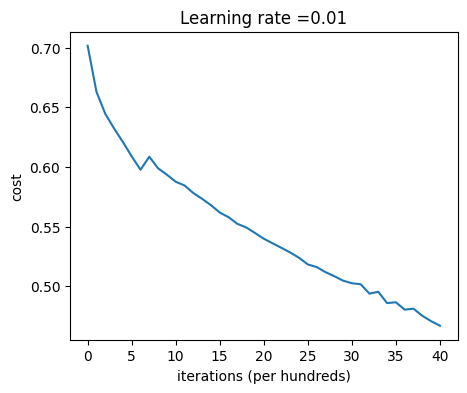

Train
Accuracy: 0.7757
Test
Accuracy: 0.6933


In [ ]:
parameters, costs = L_layer_model_with_regularization(train_x,
                                                      train_labels,
                                                      layers_dims,
                                                      learning_rate = lr,
                                                      num_iterations = 4000,
                                                      lambd=0.9,
                                                      print_cost = True)

plot_costs(costs, learning_rate = lr)

print("Train")
pred_train = predict(train_x, train_labels, parameters)

print("Test")
pred_test = predict(test_x, test_labels, parameters)

## 6 - Dropout

**Dropout** is a widely used regularization technique that is specific to deep learning. 
**It randomly shuts down some neurons in each iteration.** Watch these two videos to see what this means!


To understand drop-out, consider this conversation with a friend:
- Friend: "Why do you need all these neurons to train your network and classify images?". 
- You: "Because each neuron contains a weight and can learn specific features/details/shape of an image. The more neurons I have, the more featurse my model learns!"
- Friend: "I see, but are you sure that your neurons are learning different features and not all the same features?"
- You: "Good point... Neurons in the same layer actually don't talk to each other. It should be definitly possible that they learn the same image features/shapes/forms/details... which would be redundant. There should be a solution."


When WE shut some neurons down, you actually modify your model. The idea behind drop-out is that at each iteration, you train a different model that uses only a subset of your neurons. With dropout, your neurons thus become less sensitive to the activation of one other specific neuron, because that other neuron might be shut down at any time. 


### Forward Propagation with Dropout

Implement the forward propagation with dropout. You are using a 3 layer neural network, and will add dropout to the first and second hidden layers. We will not apply dropout to the input layer or output layer. 

You would like to shut down some neurons in the first and second layers. To do that, you are going to carry out 4 Steps:
1. We will create a variable $d^{[1]}$ with the same shape as $a^{[1]}$ using `np.random.rand()` to randomly get numbers between 0 and 1. Here, you will use a vectorized implementation, so create a random matrix $D^{[1]} = [d^{[1](1)} d^{[1](2)} ... d^{[1](m)}] $ of the same dimension as $A^{[1]}$.
2. Set each entry of $D^{[1]}$ to be 1 with probability (`keep_prob`), and 0 otherwise.

**Example:** Let's say that keep_prob = 0.8, which means that we want to keep about 80% of the neurons and drop out about 20% of them.  We want to generate a vector that has 1's and 0's, where about 80% of them are 1 and about 20% are 0.
This python statement:  
`X = (X < keep_prob).astype(int)`  

is conceptually the same as this if-else statement (for the simple case of a one-dimensional array) :

```
for i,v in enumerate(x):
    if v < keep_prob:
        x[i] = 1
    else: # v >= keep_prob
        x[i] = 0
```
Note that the `X = (X < keep_prob).astype(int)` works with multi-dimensional arrays, and the resulting output preserves the dimensions of the input array.

Also note that without using `.astype(int)`, the result is an array of booleans `True` and `False`, which Python automatically converts to 1 and 0 if we multiply it with numbers.  (However, it's better practice to convert data into the data type that we intend, so try using `.astype(int)`.)

3. Set $A^{[1]}$ to $A^{[1]} * D^{[1]}$. (You are shutting down some neurons). $D^{[1]}$ can be considered as a mask, so that when it is multiplied with another matrix, it shuts down some of the values.
4. Divide $A^{[1]}$ by `keep_prob`. By doing this you are assuring that the result of the cost will still have the same expected value as without drop-out. (This technique is also called inverted dropout.)

In [ ]:
def L_model_forward_with_dropout(X, parameters, keep_prob=0.5):
    """
    Implements the forward propagation: LINEAR -> RELU + DROPOUT -> LINEAR -> RELU + DROPOUT -> LINEAR -> SIGMOID.
    
    Arguments:
    X -- input dataset, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL"
    keep_prob -- probability of keeping a neuron active during drop-out, scalar
    
    Returns:
    AL -- last activation value, output of the forward propagation, of shape (output size, number of examples)
    caches -- list of caches containing:
                every cache of linear_activation_forward() (there are L of them, indexed from 0 to L-1)
    """
    np.random.seed(1)
    caches = []
    A = X
    L = len(parameters) // 2  # number of layers in the neural network
    
    # Implement [LINEAR -> RELU]*(L-1). Add dropout to each hidden layer
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], 'relu')
        
        D = (np.random.rand(A.shape[0], A.shape[1]) < keep_prob).astype(int)
        A = A * D
        A = A / keep_prob
        
        caches.append((cache, D))
    
    # Implement LINEAR -> SIGMOID for the output layer
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], 'sigmoid')
    caches.append(cache)
    
    assert(AL.shape == (1, X.shape[1]))

    return AL, caches


1. In backpropagation, you will have to shut down the same neurons that were previously switched off, by reapplying the same mask $D^{[l]}$ to `dAl`. 
2. We'll have to divide `dA1` by `keep_prob` (the calculus interpretation is that if $A^{[l]}$ is scaled by `keep_prob`, then its derivative $dA^{[l]}$ is also scaled by the same `keep_prob`).

In [ ]:
def L_model_backward_with_dropout(AL, Y, caches, keep_prob):
    """
    Implements the backward propagation with dropout for the neural network.
    
    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward)
    Y -- true "label" vector (containing 1 if cat, 0 if non-cat)
    caches -- list of caches containing:
                every cache of linear_activation_forward() with dropout (there are L of them, indexed from 0 to L-1)
    keep_prob -- probability of keeping a neuron active during drop-out, scalar
    
    Returns:
    grads -- A dictionary with the gradients
    """
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    
    # Initialize the backpropagation
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    # Lth layer (SIGMOID -> LINEAR) gradients
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, "sigmoid")
    
    # Loop from l=L-2 to l=0
    for l in reversed(range(L-1)):
        current_cache, _ = caches[l]
        _, D = caches[l-1]
        
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l+1)], current_cache, "relu")

        # Apply dropout mask
        dA_prev_temp = dA_prev_temp * D
        dA_prev_temp = dA_prev_temp / keep_prob
        
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l+1)] = dW_temp
        grads["db" + str(l+1)] = db_temp
    
    return grads


Let's now change the model to consider dropout:

In [ ]:
def L_layer_model_with_dropout(X, Y, layers_dims, learning_rate=0.0075, num_iterations=3000, keep_prob=0.5, print_cost=False):
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID with dropout.
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (containing 1 if cat, 0 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    keep_prob -- probability of keeping a neuron active during drop-out, scalar
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []  # keep track of cost
    
    # Parameters initialization
    parameters = initialize_parameters(layers_dims)
    
    # Reshape Y if necessary
    if Y.ndim == 1:
        Y = Y.reshape(1, -1)
    
    # Loop (gradient descent)
    for i in range(num_iterations):

        # Forward propagation
        AL, caches = L_model_forward_with_dropout(X, parameters, keep_prob)
        
        # Compute cost
        cost = compute_cost(AL, Y)
        
        # Backward propagation with dropout
        grads = L_model_backward_with_dropout(AL, Y, caches, keep_prob)
        
        # Update parameters
        parameters = update_parameters_with_gd(parameters, grads, learning_rate)
        
        # Print the cost every 100 iterations
        if print_cost and (i % 100 == 0 or i == num_iterations - 1):
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
            costs.append(cost)
    
    return parameters, costs


Cost after iteration 0: 0.6983426254886317
Cost after iteration 100: 0.668209758877791
Cost after iteration 200: 0.654255021205755
Cost after iteration 300: 0.6451696160123578
Cost after iteration 400: 0.637666840209319
Cost after iteration 500: 0.6308583930516468
Cost after iteration 600: 0.6244548153326493
Cost after iteration 700: 0.6178800744780837
Cost after iteration 800: 0.6115345830042588
Cost after iteration 900: 0.6051066673331732
Cost after iteration 1000: 0.5981662004029296
Cost after iteration 1100: 0.5916333884121725
Cost after iteration 1200: 0.584949323858122
Cost after iteration 1300: 0.578390689404062
Cost after iteration 1400: 0.572643341125443
Cost after iteration 1500: 0.5665576189891496
Cost after iteration 1600: 0.5612549158093671
Cost after iteration 1700: 0.558163459470997
Cost after iteration 1800: 0.5545984256685874
Cost after iteration 1900: 0.5501271016112912
Cost after iteration 2000: 0.5455745418950027
Cost after iteration 2100: 0.5391952884840896
Cost af

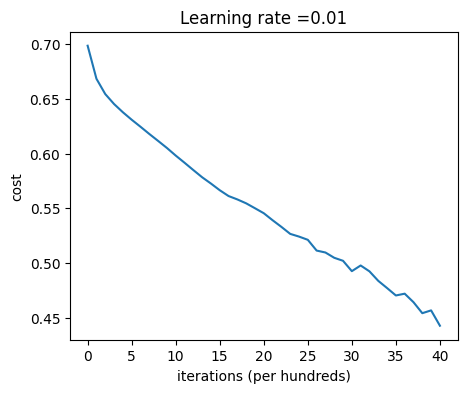

Train
Accuracy: 0.784
Test
Accuracy: 0.695


In [ ]:
parameters, costs = L_layer_model_with_dropout(train_x,
                                               train_labels,
                                               layers_dims,
                                               learning_rate=lr,
                                               num_iterations=4000,
                                               keep_prob=0.9,
                                               print_cost=True)
plot_costs(costs, learning_rate=lr)

print("Train")
pred_train = predict(train_x, train_labels, parameters)

print("Test")
pred_test = predict(test_x, test_labels, parameters)

Misclassified images: 


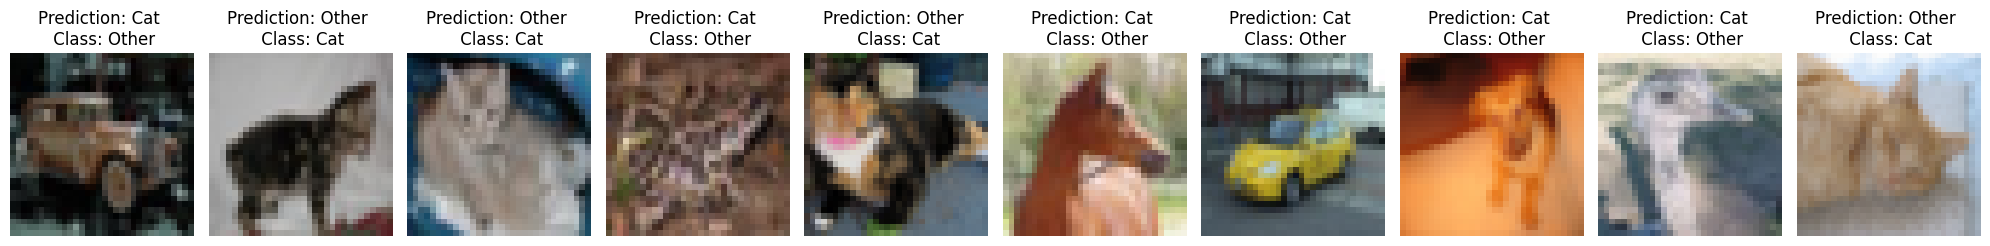

Correctly classified images: 


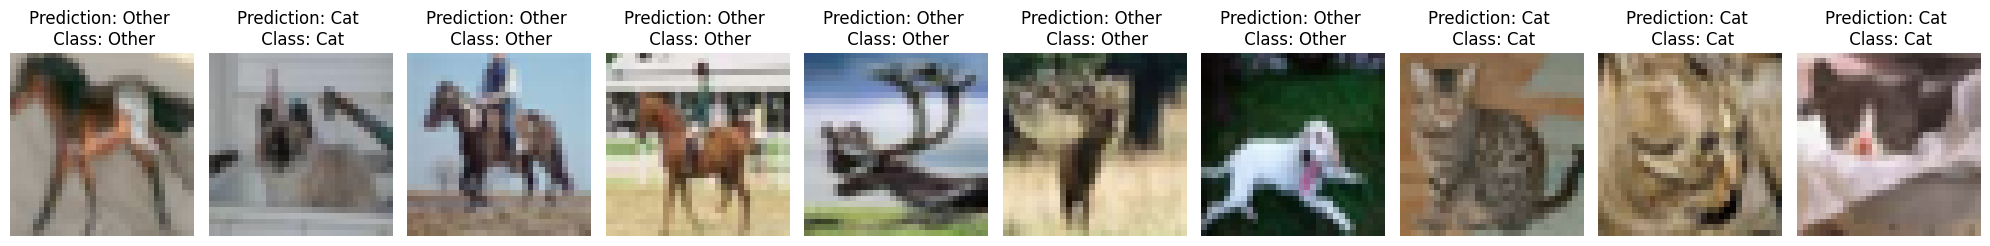

In [ ]:
print("Misclassified images: ")
print_mislabeled_images(classes, test_data, test_labels, pred_test)

print("Correctly classified images: ")
print_correctly_labeled_images(classes, test_data, test_labels, pred_test)

<font color='blue'>
    
**About dropout:**
- Dropout is a regularization technique.
- Only use dropout during training.
- Apply dropout both during forward and backward propagation.
- During training time, divide each dropout layer by keep_prob to keep the same expected value for the activations. For example, if keep_prob is 0.5, then we will on average shut down half the nodes, so the output will be scaled by 0.5 since only the remaining half are contributing to the solution. Dividing by 0.5 is equivalent to multiplying by 2. Hence, the output now has the same expected value.

## Optimization Methods

In Stochastic Gradient Descent, it is used only 1 training example before updating the gradients. When the training set is large, SGD can be faster. But the parameters will "oscillate" toward the minimum rather than converge smoothly. Here's what that looks like: 

<center><img src="images/kiank_sgd.png" style="width:750px;height:250px;"></center>
<caption><center> <u> <font color='purple'> <b>Figure 6</b> </u><font color='purple'>  : <b>SGD vs GD</b><br> "+" denotes a minimum of the cost. SGD leads to many oscillations to reach convergence, but each step is a lot faster to compute for SGD than it is for GD, as it uses only one training example (vs. the whole batch for GD). </center></caption>

**Note** also that implementing SGD requires 3 for-loops in total:
1. Over the number of iterations
2. Over the $m$ training examples
3. Over the layers (to update all parameters, from $(W^{[1]},b^{[1]})$ to $(W^{[L]},b^{[L]})$)

In practice, it is faster to not use the entire training set, or just one training example, to perform each update. Mini-batch gradient descent uses an intermediate number of examples for each step. The mini-batch gradient descent loopes over the mini-batches instead of looping over individual training examples.

<center><img src="images/kiank_minibatch.png" style="width:750px;height:250px;"></center>
<caption><center> <u> <font color='purple'> <b>Figure 7</b> </u>: <font color='purple'>  <b>SGD vs Mini-Batch GD</b><br> "+" denotes a minimum of the cost. Using mini-batches in your optimization algorithm often leads to faster optimization. </center></caption>

### Mini-Batch Gradient Descent

There are two steps to implement mini-batch gradient descent:
- **Shuffle**: Create a shuffled version of the training set (X, Y) as shown below. Each column of X and Y represents a training example. The random shuffling is done synchronously between X and Y, such that after the shuffling the $i^{th}$ column of X is the example corresponding to the $i^{th}$ label in Y. The shuffling step ensures that examples will be split randomly into different mini-batches. 

<center><img src="images/kiank_shuffle.png" style="width:550px;height:300px;"></center>

- **Partition**: Partition the shuffled (X, Y) into mini-batches of size `mini_batch_size` (here 64). The number of training examples is not always divisible by `mini_batch_size`, so the last mini batch might be smaller. When this happens it will look like this: 

<center><img src="images/kiank_partition.png" style="width:550px;height:300px;"></center>

Powers of two are often chosen to be the mini-batch size, e.g., 16, 32, 64, 128.

In [ ]:
def random_mini_batches(X, Y, mini_batch_size=64, seed=0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    mini_batch_size -- size of the mini-batches, integer
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    np.random.seed(seed)            # To make your "random" minibatches the same as ours
    m = X.shape[1]                  # number of training examples
    mini_batches = []
        
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[permutation].reshape((1, m))
    
    inc = mini_batch_size
    
    # Step 2 - Partition (shuffled_X, shuffled_Y).
    # Cases with a complete mini batch size only i.e each of 64 examples.
    num_complete_minibatches = math.floor(m / mini_batch_size) # number of mini batches of size mini_batch_size in your partitioning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, inc*k:inc*(k+1)]
        mini_batch_Y = shuffled_Y[:, inc*k:inc*(k+1)]
        
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # For handling the end case (last mini-batch < mini_batch_size i.e less than 64)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, inc*num_complete_minibatches:]
        mini_batch_Y = shuffled_Y[:, inc*num_complete_minibatches:]
        
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

## Momentum

Because mini-batch gradient descent makes a parameter update after seeing just a subset of examples, the direction of the update has some variance, and so the path taken by mini-batch gradient descent will "oscillate" toward convergence. Using momentum can reduce these oscillations. 

Momentum takes into account the past gradients to smooth out the update. The 'direction' of the previous gradients is stored in the variable $v$. Formally, this will be the exponentially weighted average of the gradient on previous steps. It is possile to think of $v$ as the "velocity" of a ball rolling downhill, building up speed (and momentum) according to the direction of the gradient/slope of the hill. This technique is also used to filter temperatures throughout days and make a linear curve of it.

<center><img src="images/opt_momentum.png" style="width:400px;height:250px;"></center>
<caption><center> <u><font color='purple'><b>Figure 3</b> </u><font color='purple'>: The red arrows show the direction taken by one step of mini-batch gradient descent with momentum. The blue points show the direction of the gradient (with respect to the current mini-batch) on each step. Rather than just following the gradient, the gradient is allowed to influence $v$ and then take a step in the direction of $v$.<br> <font color='black'> </center>

In [ ]:
def initialize_velocity(parameters):
    """
    Initializes the velocity as a python dictionary with:
                - keys: "dW1", "db1", ..., "dWL", "dbL" 
                - values: numpy arrays of zeros of the same shape as the corresponding gradients/parameters.
    Arguments:
    parameters -- python dictionary containing your parameters.
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    
    Returns:
    v -- python dictionary containing the current velocity.
                    v['dW' + str(l)] = velocity of dWl
                    v['db' + str(l)] = velocity of dbl
    """
    
    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}

    for l in range(1, L + 1):
        v["dW" + str(l)] = np.zeros((parameters["W" + str(l)].shape[0], parameters["W" + str(l)].shape[1]))
        v["db" + str(l)] = np.zeros((parameters["b" + str(l)].shape[0], parameters["b" + str(l)].shape[1]))
        
    return v

Now, implementing the parameters update with momentum. The momentum update rule is, for $l = 1, ..., L$: 

$$ \begin{cases}
v_{dW^{[l]}} = \beta v_{dW^{[l]}} + (1 - \beta) dW^{[l]} \\
W^{[l]} = W^{[l]} - \alpha v_{dW^{[l]}}
\end{cases}\tag{3}$$

$$\begin{cases}
v_{db^{[l]}} = \beta v_{db^{[l]}} + (1 - \beta) db^{[l]} \\
b^{[l]} = b^{[l]} - \alpha v_{db^{[l]}} 
\end{cases}\tag{4}$$

where L is the number of layers, $\beta$ is the momentum and $\alpha$ is the learning rate. All parameters should be stored in the `parameters` dictionary.  Note that the iterator `l` starts at 1 in the `for` loop as the first parameters are $W^{[1]}$ and $b^{[1]}$ (that's a "one" on the superscript).

In [ ]:
def update_parameters_with_momentum(parameters, grads, v, beta, learning_rate):
    """
    Update parameters using Momentum
    
    Arguments:
    parameters -- python dictionary containing your parameters:
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    grads -- python dictionary containing your gradients for each parameters:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    v -- python dictionary containing the current velocity:
                    v['dW' + str(l)] = ...
                    v['db' + str(l)] = ...
    beta -- the momentum hyperparameter, scalar
    learning_rate -- the learning rate, scalar
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    v -- python dictionary containing your updated velocities
    """

    L = len(parameters) // 2 # number of layers in the neural networks
    
    for l in range(1, L + 1):
        v["dW" + str(l)] = beta * v["dW" + str(l)] + (1 - beta) * grads["dW" + str(l)]
        v["db" + str(l)] = beta * v["db" + str(l)] + (1 - beta) * grads["db" + str(l)]
        
        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate * v["dW" + str(l)]
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate * v["db" + str(l)]
        
    return parameters, v

**Note that**:
- The velocity is initialized with zeros. So the algorithm will take a few iterations to "build up" velocity and start to take bigger steps.
- If $\beta = 0$, then this just becomes standard gradient descent without momentum. 

**How to choose $\beta$?**
- The larger the momentum $\beta$ is, the smoother the update, because it takes the past gradients into account more. But if $\beta$ is too big, it could also smooth out the updates too much. 
- Common values for $\beta$ range from 0.8 to 0.999. If you don't feel inclined to tune this, $\beta = 0.9$ is often a reasonable default. 
- Tuning the optimal $\beta$ for your model might require trying several values to see what works best in terms of reducing the value of the cost function $J$. 

## Adam

Adam is one of the most effective optimization algorithms for training neural networks. It combines ideas from RMSProp (described in lecture) and Momentum. 

**How does Adam work?**
1. It calculates an exponentially weighted average of past gradients, and stores it in variables $v$ (before bias correction) and $v^{corrected}$ (with bias correction). 
2. It calculates an exponentially weighted average of the squares of the past gradients, and  stores it in variables $s$ (before bias correction) and $s^{corrected}$ (with bias correction). 
3. It updates parameters in a direction based on combining information from "1" and "2".

The update rule is, for $l = 1, ..., L$: 

$$\begin{cases}
v_{dW^{[l]}} = \beta_1 v_{dW^{[l]}} + (1 - \beta_1) \frac{\partial \mathcal{J} }{ \partial W^{[l]} } \\
v^{corrected}_{dW^{[l]}} = \frac{v_{dW^{[l]}}}{1 - (\beta_1)^t} \\
s_{dW^{[l]}} = \beta_2 s_{dW^{[l]}} + (1 - \beta_2) (\frac{\partial \mathcal{J} }{\partial W^{[l]} })^2 \\
s^{corrected}_{dW^{[l]}} = \frac{s_{dW^{[l]}}}{1 - (\beta_2)^t} \\
W^{[l]} = W^{[l]} - \alpha \frac{v^{corrected}_{dW^{[l]}}}{\sqrt{s^{corrected}_{dW^{[l]}}} + \varepsilon}
\end{cases}$$

where:
- t counts the number of steps taken of Adam 
- L is the number of layers
- $\beta_1$ and $\beta_2$ are hyperparameters that control the two exponentially weighted averages. 
- $\alpha$ is the learning rate
- $\varepsilon$ is a very small number to avoid dividing by zero

As usual, all parameters are stored in the `parameters` dictionary  

In [ ]:
def initialize_adam(parameters):
    """
    Initializes v and s as two python dictionaries with keys as "dW1", "db1", ..., "dWL", "dbL".
    
    Arguments:
    parameters -- python dictionary containing your parameters.
    
    Returns:
    v -- python dictionary containing the exponentially weighted average of the gradient.
    s -- python dictionary containing the exponentially weighted average of the squared gradient.
    """
    v = {}
    s = {}
    L = len(parameters) // 2  # number of layers in the neural networks
    
    for l in range(1, L + 1):
        v["dW" + str(l)] = np.zeros_like(parameters["W" + str(l)])
        v["db" + str(l)] = np.zeros_like(parameters["b" + str(l)])
        s["dW" + str(l)] = np.zeros_like(parameters["W" + str(l)])
        s["db" + str(l)] = np.zeros_like(parameters["b" + str(l)])
        
    return v, s

Now, implementing the parameters update with Adam. Recall the general update rule is, for $l = 1, ..., L$: 

$$\begin{cases}
v_{dW^{[l]}} = \beta_1 v_{dW^{[l]}} + (1 - \beta_1) \frac{\partial \mathcal{J} }{ \partial W^{[l]} } \\
v^{corrected}_{dW^{[l]}} = \frac{v_{dW^{[l]}}}{1 - (\beta_1)^t} \\
s_{dW^{[l]}} = \beta_2 s_{dW^{[l]}} + (1 - \beta_2) (\frac{\partial \mathcal{J} }{\partial W^{[l]} })^2 \\
s^{corrected}_{dW^{[l]}} = \frac{s_{dW^{[l]}}}{1 - (\beta_2)^t} \\
W^{[l]} = W^{[l]} - \alpha \frac{v^{corrected}_{dW^{[l]}}}{\sqrt{s^{corrected}_{dW^{[l]}}} + \varepsilon}
\end{cases}$$


**Note** that the iterator `l` starts at 1 in the `for` loop as the first parameters are $W^{[1]}$ and $b^{[1]}$. 

In [ ]:
def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate = 0.01,
                                beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8):
    """
    Update parameters using Adam
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of L_model_backward
    v -- Adam variable, moving average of the first gradient, python dictionary
    s -- Adam variable, moving average of the squared gradient, python dictionary
    t -- Adam variable, counts the number of iterations
    learning_rate -- the learning rate, scalar
    beta1 -- Exponential decay hyperparameter for the first moment estimates 
    beta2 -- Exponential decay hyperparameter for the second moment estimates 
    epsilon -- hyperparameter preventing division by zero in Adam updates

    Returns:
    parameters -- python dictionary containing your updated parameters 
    v -- Adam variable, moving average of the first gradient, python dictionary
    s -- Adam variable, moving average of the squared gradient, python dictionary
    """
    L = len(parameters) // 2  # number of layers in the neural networks
    v_corrected = {}          # Initializing first moment estimate, python dictionary
    s_corrected = {}          # Initializing second moment estimate, python dictionary
    
    # Perform Adam update on all parameters
    for l in range(1, L + 1):
        # Moving average of the gradients
        v["dW" + str(l)] = beta1 * v["dW" + str(l)] + (1 - beta1) * grads["dW" + str(l)]
        v["db" + str(l)] = beta1 * v["db" + str(l)] + (1 - beta1) * grads["db" + str(l)]

        # Compute bias-corrected first moment estimate
        v_corrected["dW" + str(l)] = v["dW" + str(l)] / (1 - np.power(beta1, t))
        v_corrected["db" + str(l)] = v["db" + str(l)] / (1 - np.power(beta1, t))

        # Moving average of the squared gradients
        s["dW" + str(l)] = beta2 * s["dW" + str(l)] + (1 - beta2) * np.square(grads["dW" + str(l)])
        s["db" + str(l)] = beta2 * s["db" + str(l)] + (1 - beta2) * np.square(grads["db" + str(l)])

        # Compute bias-corrected second raw moment estimate
        s_corrected["dW" + str(l)] = s["dW" + str(l)] / (1 - np.power(beta2, t))
        s_corrected["db" + str(l)] = s["db" + str(l)] / (1 - np.power(beta2, t))

        # Update parameters
        parameters["W" + str(l)] -= learning_rate * (v_corrected["dW" + str(l)] / (np.sqrt(s_corrected["dW" + str(l)]) + epsilon))
        parameters["b" + str(l)] -= learning_rate * (v_corrected["db" + str(l)] / (np.sqrt(s_corrected["db" + str(l)]) + epsilon))

    return parameters, v, s

## Model with different Optimization algorithms

In [116]:
def compute_cost(AL, Y):
    m = Y.shape[1]
    epsilon = 1e-8  # small value to prevent log(0)
    cost = (1./m) * (-np.dot(Y, np.log(AL + epsilon).T) - np.dot(1-Y, np.log(1-AL + epsilon).T))
    cost = np.squeeze(cost)
    
    return cost


def L_model_backward(AL, Y, caches):
    """
    Implementa a passagem para trás para a rede [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID
    
    Argumentos:
    AL -- ativação pós-ativa, saída da passagem para frente (L_model_forward)
    Y -- vetor de verdadeiros "rótulos" (0 se não é pizza, 1 se é pizza)
    caches -- lista de caches contendo:
                cada cache do linear_activation_forward() com "relu" (há L-1, indexado de 0 a L-2)
                o cache do linear_activation_forward() com "sigmoid" (há 1, indexado L-1)
    
    Retorna:
    grads -- dicionário com os gradientes com relação a cada parâmetro, ativação e pré-ativação variável
    """
    grads = {}
    L = len(caches)  # número de camadas
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)  # Assegure-se de que Y tenha o mesmo formato que AL
    epsilon = 1e-8  # small value to prevent division by 0

    # Inicialize a retropropagação
    dAL = -(np.divide(Y, AL + epsilon) - np.divide(1 - Y, 1 - AL + epsilon))
    
    # Camada L: dAL -> SIGMOID -> LINEAR gradients.
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation="sigmoid")
    
    # Loop da camada L-1 até a camada 0
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, activation="relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads



In [114]:
def model(X, Y, layers_dims, optimizer, learning_rate=0.0007, mini_batch_size=64, beta=0.9,
          beta1=0.9, beta2=0.999,  epsilon=1e-8, num_epochs=5000, print_cost=True):
    """
    Neural network model which can be run in different optimizer modes.
    
    Arguments:
    X -- input data, of shape (2, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    optimizer -- the optimizer to be passed, gradient descent, momentum or adam
    layers_dims -- python list, containing the size of each layer
    learning_rate -- the learning rate, scalar.
    mini_batch_size -- the size of a mini batch
    beta -- Momentum hyperparameter
    beta1 -- Exponential decay hyperparameter for the past gradients estimates 
    beta2 -- Exponential decay hyperparameter for the past squared gradients estimates 
    epsilon -- hyperparameter preventing division by zero in Adam updates
    num_epochs -- number of epochs
    print_cost -- True to print the cost every 1000 epochs

    Returns:
    parameters -- python dictionary containing your updated parameters 
    """

    L = len(layers_dims)             # number of layers in the neural networks
    costs = []                       # to keep track of the cost
    t = 0                            # initializing the counter required for Adam update
    seed = 10                        # For grading purposes, so that your "random" minibatches are the same as ours
    m = X.shape[1]                   # number of training examples
    
    # Initialize parameters
    parameters = initialize_parameters(layers_dims)

    # Initialize the optimizer
    if optimizer == "gd":
        pass # no initialization required for gradient descent
    elif optimizer == "momentum":
        v = initialize_velocity(parameters)
    elif optimizer == "adam":
        v, s = initialize_adam(parameters)
    
    # Optimization loop
    for i in range(num_epochs):
        
        # Define the random minibatches. We increment the seed to reshuffle differently the dataset after each epoch
        seed = seed + 1
        minibatches = random_mini_batches(X, Y, mini_batch_size, seed)
        cost_total = 0
        
        for minibatch in minibatches:

            # Select a minibatch
            (minibatch_X, minibatch_Y) = minibatch

            # Forward propagation
            AL, caches = L_model_forward(minibatch_X, parameters)

            # Compute cost and add to the cost total
            cost_total += compute_cost(AL, minibatch_Y)

            # Backward propagation
            grads = L_model_backward(AL, minibatch_Y, caches)

            # Update parameters
            if optimizer == "gd":
                parameters = update_parameters_with_gd(parameters, grads, learning_rate)
            elif optimizer == "momentum":
                parameters, v = update_parameters_with_momentum(parameters, grads, v, beta, learning_rate)
            elif optimizer == "adam":
                t = t + 1 # Adam counter
                parameters, v, s = update_parameters_with_adam(parameters, grads, v, s,
                                                               t, learning_rate, beta1, beta2, epsilon)
        cost_avg = cost_total / m
        
        # Print the cost every 1000 epoch
        if print_cost and i % 100 == 0:
            print("Cost after epoch %i: %f" % (i, cost_avg))
        if print_cost and i % 100 == 0:
            costs.append(cost_avg)
                
    # plot the cost
    plt.rcParams['figure.figsize'] = (5.0, 4.0)
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()

    return parameters

### Gradient Descent

Cost after epoch 0: 0.010875
Cost after epoch 100: 0.009809
Cost after epoch 200: 0.009229
Cost after epoch 300: 0.008696
Cost after epoch 400: 0.008212
Cost after epoch 500: 0.007779
Cost after epoch 600: 0.007247
Cost after epoch 700: 0.006781
Cost after epoch 800: 0.006096
Cost after epoch 900: 0.005957
Cost after epoch 1000: 0.005585
Cost after epoch 1100: 0.004627
Cost after epoch 1200: 0.004851
Cost after epoch 1300: 0.004590
Cost after epoch 1400: 0.004049
Cost after epoch 1500: 0.003828
Cost after epoch 1600: 0.003926
Cost after epoch 1700: 0.002387
Cost after epoch 1800: 0.001611
Cost after epoch 1900: 0.002298
Cost after epoch 2000: 0.001180
Cost after epoch 2100: 0.000880
Cost after epoch 2200: 0.000707
Cost after epoch 2300: 0.000561
Cost after epoch 2400: 0.000476
Cost after epoch 2500: 0.000405
Cost after epoch 2600: 0.000353
Cost after epoch 2700: 0.000312
Cost after epoch 2800: 0.000279
Cost after epoch 2900: 0.000253
Cost after epoch 3000: 0.000230
Cost after epoch 310

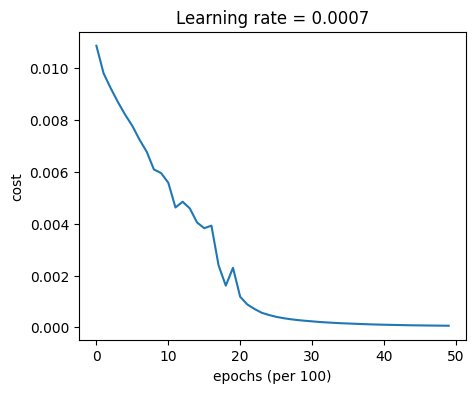

Train
Accuracy: 0.9983
Test
Accuracy: 0.6767


In [ ]:
parameters = model(X = train_x,
                   Y = train_labels,
                   layers_dims = layers_dims,
                   optimizer = "gd")

print("Train")
pred_train = predict(train_x, train_labels, parameters)

print("Test")
pred_test = predict(test_x, test_labels, parameters)

### Momentum

Cost after epoch 0: 0.010883
Cost after epoch 100: 0.009779
Cost after epoch 200: 0.009195
Cost after epoch 300: 0.008656
Cost after epoch 400: 0.008179
Cost after epoch 500: 0.007668
Cost after epoch 600: 0.007175
Cost after epoch 700: 0.006549
Cost after epoch 800: 0.005904
Cost after epoch 900: 0.005257
Cost after epoch 1000: 0.004465
Cost after epoch 1100: 0.003802
Cost after epoch 1200: 0.003092
Cost after epoch 1300: 0.002546
Cost after epoch 1400: 0.001997
Cost after epoch 1500: 0.001483
Cost after epoch 1600: 0.001142
Cost after epoch 1700: 0.000955
Cost after epoch 1800: 0.000747
Cost after epoch 1900: 0.000549
Cost after epoch 2000: 0.000431
Cost after epoch 2100: 0.000372
Cost after epoch 2200: 0.000315
Cost after epoch 2300: 0.000281
Cost after epoch 2400: 0.000249
Cost after epoch 2500: 0.000228
Cost after epoch 2600: 0.000210
Cost after epoch 2700: 0.000184
Cost after epoch 2800: 0.000167
Cost after epoch 2900: 0.000143
Cost after epoch 3000: 0.000130
Cost after epoch 310

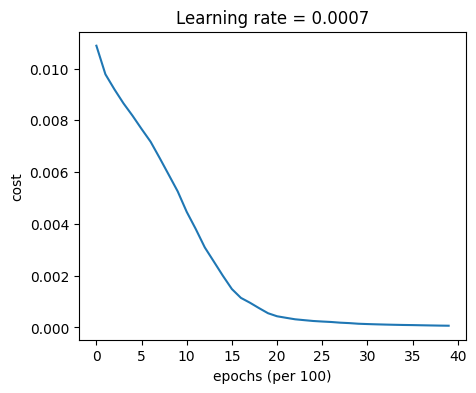

Train
Accuracy: 0.999
Test
Accuracy: 0.6517


In [ ]:
parameters = model(X = train_x,
                   Y = train_labels,
                   layers_dims = layers_dims,
                   optimizer = "momentum",
                   num_epochs = 4000)

print("Train")
pred_train = predict(train_x, train_labels, parameters)

print("Test")
pred_test = predict(test_x, test_labels, parameters)

Misclassified images: 


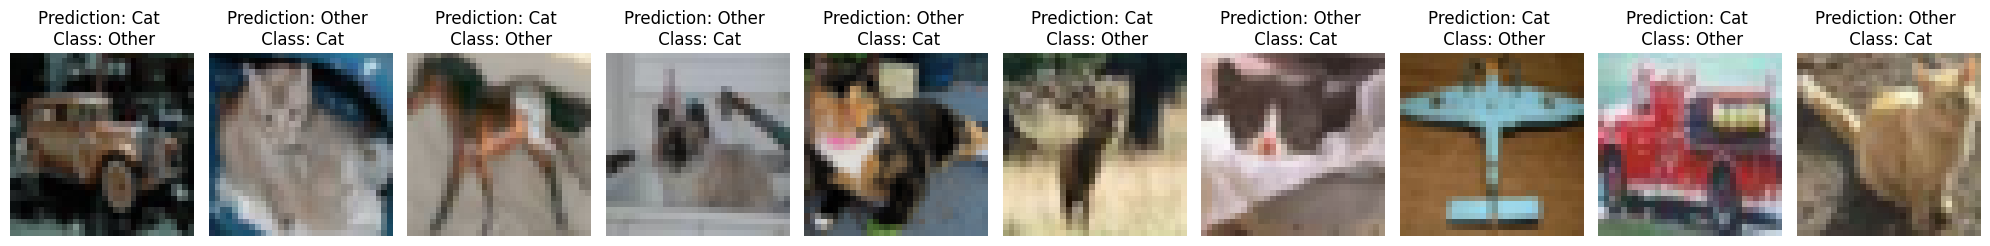

Correctly classified images: 


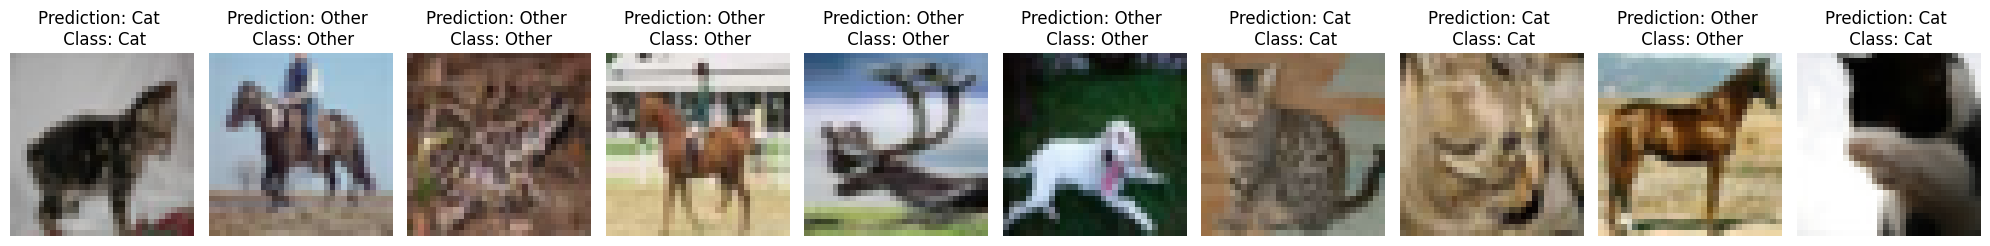

In [ ]:
print("Misclassified images: ")
print_mislabeled_images(classes, test_data, test_labels, pred_test)

print("Correctly classified images: ")
print_correctly_labeled_images(classes, test_data, test_labels, pred_test)

### Adam

Cost after epoch 0: 0.010750
Cost after epoch 100: 0.008803
Cost after epoch 200: 0.007952
Cost after epoch 300: 0.007178
Cost after epoch 400: 0.006459
Cost after epoch 500: 0.005845
Cost after epoch 600: 0.005362
Cost after epoch 700: 0.004880
Cost after epoch 800: 0.004484
Cost after epoch 900: 0.004151
Cost after epoch 1000: 0.003738
Cost after epoch 1100: 0.003436
Cost after epoch 1200: 0.003187
Cost after epoch 1300: 0.002936
Cost after epoch 1400: 0.002604
Cost after epoch 1500: 0.002360
Cost after epoch 1600: 0.002261
Cost after epoch 1700: 0.001976
Cost after epoch 1800: 0.001748
Cost after epoch 1900: 0.001582
Cost after epoch 2000: 0.001439
Cost after epoch 2100: 0.001272
Cost after epoch 2200: 0.001093
Cost after epoch 2300: 0.000978
Cost after epoch 2400: 0.000839
Cost after epoch 2500: 0.000743
Cost after epoch 2600: 0.000669
Cost after epoch 2700: 0.000565
Cost after epoch 2800: 0.000513
Cost after epoch 2900: 0.000451
Cost after epoch 3000: 0.000384
Cost after epoch 310

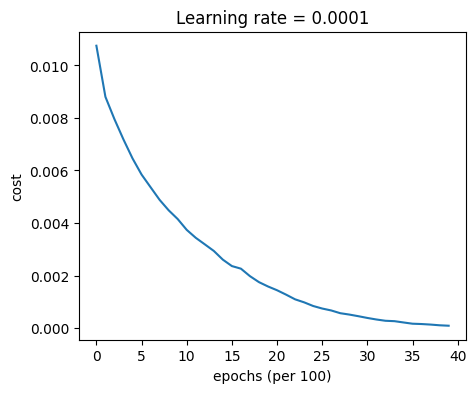

Train
Accuracy: 1.0
Test
Accuracy: 0.6367


In [117]:
parameters = model(X = train_x,
                   Y = train_labels,
                   layers_dims = layers_dims,
                   optimizer = "adam",
                   num_epochs=4000,
                   learning_rate=0.0001)

print("Train")
pred_train = predict(train_x, train_labels, parameters)

print("Test")
pred_test = predict(test_x, test_labels, parameters)

Misclassified images: 


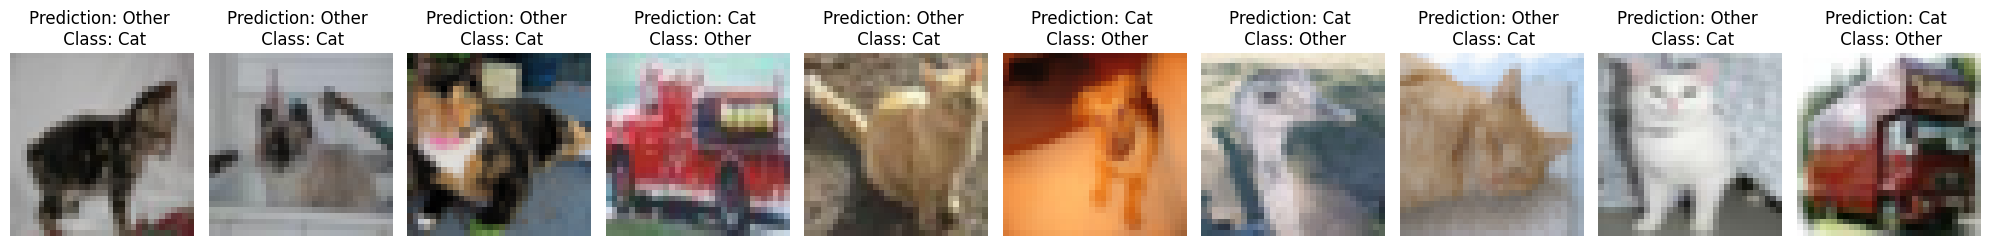

Correctly classified images: 


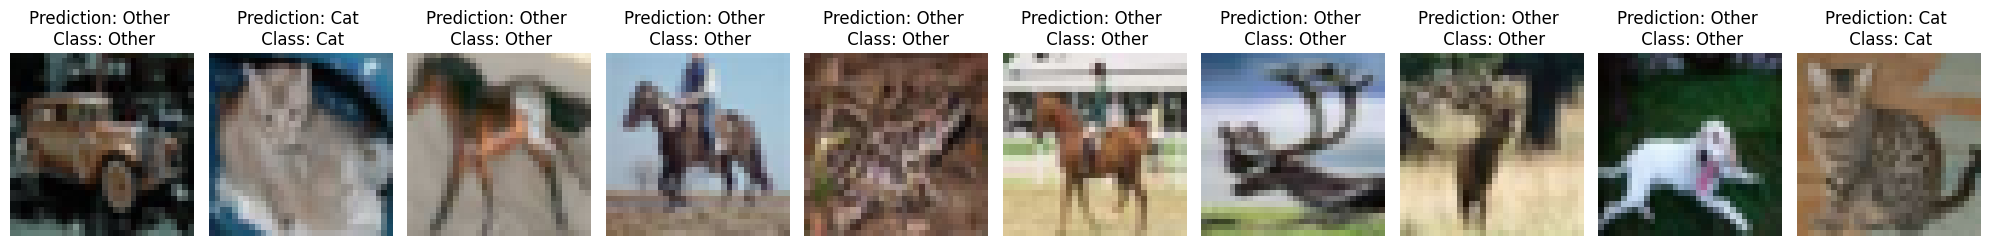

In [118]:
print("Misclassified images: ")
print_mislabeled_images(classes, test_data, test_labels, pred_test)

print("Correctly classified images: ")
print_correctly_labeled_images(classes, test_data, test_labels, pred_test)

Some advantages of Adam include:

- Relatively low memory requirements (though higher than gradient descent and gradient descent with momentum) 
- Usually works well even with little tuning of hyperparameters (except $\alpha$)

**References**:

- Adam paper: https://arxiv.org/pdf/1412.6980.pdf

## Learning Rate Decay and Scheduling

The learning rate is another hyperparameter that can help speed up learning. 

During the first part of training, the model can get away with taking large steps, but over time, using a fixed value for the learning rate alpha can cause the model to get stuck in a wide oscillation that never quite converges. But if we slowly reduce the learning rate over time, the algorithm could then take smaller, slower steps that bring gets closer to the minimum. This is the idea behind learning rate decay. 

Learning rate decay can be achieved by using either adaptive methods or pre-defined learning rate schedules. 

This model is essentially the same as before, except in this one it is possible to include learning rate decay. It includes two new parameters, decay and decay_rate. 

In [119]:
def model(X, Y, layers_dims, optimizer, learning_rate = 0.0007, mini_batch_size = 64, beta = 0.9,
          beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8, num_epochs = 5000, print_cost = True, decay=None, decay_rate=1):
    """
    3-layer neural network model which can be run in different optimizer modes.
    
    Arguments:
    X -- input data, of shape (2, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    layers_dims -- python list, containing the size of each layer
    learning_rate -- the learning rate, scalar.
    mini_batch_size -- the size of a mini batch
    beta -- Momentum hyperparameter
    beta1 -- Exponential decay hyperparameter for the past gradients estimates 
    beta2 -- Exponential decay hyperparameter for the past squared gradients estimates 
    epsilon -- hyperparameter preventing division by zero in Adam updates
    num_epochs -- number of epochs
    print_cost -- True to print the cost every 1000 epochs

    Returns:
    parameters -- python dictionary containing your updated parameters 
    """

    L = len(layers_dims)             # number of layers in the neural networks
    costs = []                       # to keep track of the cost
    t = 0                            # initializing the counter required for Adam update
    seed = 10                        # For grading purposes, so that your "random" minibatches are the same as ours
    m = X.shape[1]                   # number of training examples
    lr_rates = []
    learning_rate0 = learning_rate   # the original learning rate
    
    # Initialize parameters
    parameters = initialize_parameters(layers_dims)

    # Initialize the optimizer
    if optimizer == "gd":
        pass # no initialization required for gradient descent
    elif optimizer == "momentum":
        v = initialize_velocity(parameters)
    elif optimizer == "adam":
        v, s = initialize_adam(parameters)
    
    # Optimization loop
    for i in range(num_epochs):
        
        # Define the random minibatches. We increment the seed to reshuffle differently the dataset after each epoch
        seed = seed + 1
        minibatches = random_mini_batches(X, Y, mini_batch_size, seed)
        cost_total = 0
        
        for minibatch in minibatches:

            # Select a minibatch
            (minibatch_X, minibatch_Y) = minibatch
            
            # Forward propagation
            AL, caches = L_model_forward(minibatch_X, parameters)

            # Compute cost and add to the cost total
            cost_total += compute_cost(AL, minibatch_Y)

            # Backward propagation
            grads = L_model_backward(AL, minibatch_Y, caches)

            # Update parameters
            if optimizer == "gd":
                parameters = update_parameters_with_gd(parameters, grads, learning_rate)
            elif optimizer == "momentum":
                parameters, v = update_parameters_with_momentum(parameters, grads, v, beta, learning_rate)
            elif optimizer == "adam":
                t = t + 1 # Adam counter
                parameters, v, s = update_parameters_with_adam(parameters, grads, v, s,
                                                               t, learning_rate, beta1, beta2,  epsilon)
        cost_avg = cost_total / m
        if decay:
            learning_rate = decay(learning_rate0, i, decay_rate)
        
        # Print the cost every 100 epoch
        if print_cost and i % 100 == 0:
            print ("Cost after epoch %i: %f" %(i, cost_avg))
            if decay:
                print("learning rate after epoch %i: %f"%(i, learning_rate))
        if print_cost and i % 100 == 0:
            costs.append(cost_avg)
                
    # plot the cost
    plt.rcParams['figure.figsize'] = (5.0, 4.0)
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()

    return parameters

### Decay on every iteration  
One of the pre-defined schedules for learning rate decay is called exponential learning rate decay. It takes this mathematical form:

$$\alpha = \frac{1}{1 + decayRate \times epochNumber} \alpha_{0}$$


In [120]:
def update_lr(learning_rate0, epoch_num, decay_rate):
    """
    Calculates updated the learning rate using exponential weight decay.
    
    Arguments:
    learning_rate0 -- Original learning rate. Scalar
    epoch_num -- Epoch number. Integer
    decay_rate -- Decay rate. Scalar

    Returns:
    learning_rate -- Updated learning rate. Scalar 
    """
    
    learning_rate = learning_rate0 / (1 + decay_rate * epoch_num)
    
    return learning_rate

Cost after epoch 0: 0.010836
learning rate after epoch 0: 0.001000
Cost after epoch 100: 0.010179
learning rate after epoch 100: 0.000010
Cost after epoch 200: 0.010118
learning rate after epoch 200: 0.000005
Cost after epoch 300: 0.010089
learning rate after epoch 300: 0.000003
Cost after epoch 400: 0.010066
learning rate after epoch 400: 0.000002
Cost after epoch 500: 0.010049
learning rate after epoch 500: 0.000002
Cost after epoch 600: 0.010034
learning rate after epoch 600: 0.000002
Cost after epoch 700: 0.010026
learning rate after epoch 700: 0.000001
Cost after epoch 800: 0.010017
learning rate after epoch 800: 0.000001
Cost after epoch 900: 0.010006
learning rate after epoch 900: 0.000001
Cost after epoch 1000: 0.009999
learning rate after epoch 1000: 0.000001
Cost after epoch 1100: 0.009992
learning rate after epoch 1100: 0.000001
Cost after epoch 1200: 0.009987
learning rate after epoch 1200: 0.000001
Cost after epoch 1300: 0.009983
learning rate after epoch 1300: 0.000001
Co

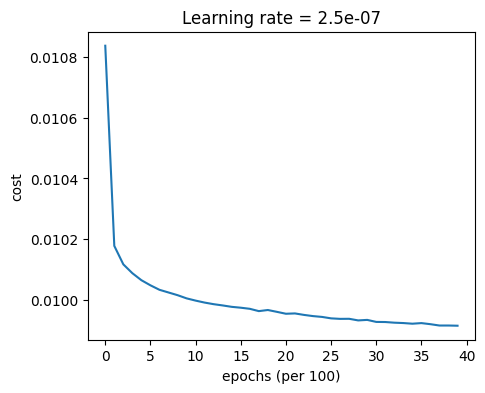

Train
Accuracy: 0.6747
Test
Accuracy: 0.645


In [121]:
parameters = model(X = train_x,
                   Y = train_labels,
                   layers_dims = layers_dims,
                   optimizer = "adam",
                   num_epochs=4000,
                   learning_rate=0.001,
                   decay=update_lr)

print("Train")
pred_train = predict(train_x, train_labels, parameters)

print("Test")
pred_test = predict(test_x, test_labels, parameters)

### Fixed Interval Scheduling

We can prevent the learning rate speeding to zero too quickly by scheduling the exponential learning rate decay at a fixed time interval, for example 1000.

<center><img src="images/lr.png" style="width:400px;height:250px;"></center>

In [122]:
def schedule_lr_decay(learning_rate0, epoch_num, decay_rate, time_interval=1000):
    """
    Calculates updated the learning rate using exponential weight decay.
    
    Arguments:
    learning_rate0 -- Original learning rate. Scalar
    epoch_num -- Epoch number. Integer.
    decay_rate -- Decay rate. Scalar.
    time_interval -- Number of epochs where you update the learning rate.

    Returns:
    learning_rate -- Updated learning rate. Scalar 
    """

    learning_rate = learning_rate0 / (1 + decay_rate * np.floor(epoch_num / time_interval))
    
    return learning_rate

Cost after epoch 0: 0.010934
learning rate after epoch 0: 0.001000
Cost after epoch 100: 0.009727
learning rate after epoch 100: 0.001000
Cost after epoch 200: 0.009403
learning rate after epoch 200: 0.001000
Cost after epoch 300: 0.009197
learning rate after epoch 300: 0.001000
Cost after epoch 400: 0.009011
learning rate after epoch 400: 0.001000
Cost after epoch 500: 0.008866
learning rate after epoch 500: 0.001000
Cost after epoch 600: 0.008702
learning rate after epoch 600: 0.001000
Cost after epoch 700: 0.008574
learning rate after epoch 700: 0.001000
Cost after epoch 800: 0.008409
learning rate after epoch 800: 0.001000
Cost after epoch 900: 0.008263
learning rate after epoch 900: 0.001000
Cost after epoch 1000: 0.008053
learning rate after epoch 1000: 0.000500
Cost after epoch 1100: 0.007909
learning rate after epoch 1100: 0.000500
Cost after epoch 1200: 0.007806
learning rate after epoch 1200: 0.000500
Cost after epoch 1300: 0.007692
learning rate after epoch 1300: 0.000500
Co

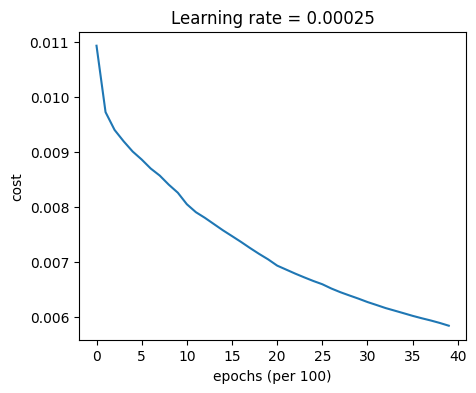

Train
Accuracy: 0.8483
Test
Accuracy: 0.6667


In [124]:
parameters = model(X = train_x,
                   Y = train_labels,
                   layers_dims = layers_dims,
                   optimizer = "gd",
                   num_epochs=4000,
                   learning_rate=0.001,
                   decay=schedule_lr_decay)

print("Train")
pred_train = predict(train_x, train_labels, parameters)

print("Test")
pred_test = predict(test_x, test_labels, parameters)

Cost after epoch 0: 0.010836
learning rate after epoch 0: 0.001000
Cost after epoch 100: 0.008625
learning rate after epoch 100: 0.001000
Cost after epoch 200: 0.007792
learning rate after epoch 200: 0.001000
Cost after epoch 300: 0.007462
learning rate after epoch 300: 0.001000
Cost after epoch 400: 0.006897
learning rate after epoch 400: 0.001000
Cost after epoch 500: 0.006448
learning rate after epoch 500: 0.001000
Cost after epoch 600: 0.006435
learning rate after epoch 600: 0.001000
Cost after epoch 700: 0.005914
learning rate after epoch 700: 0.001000
Cost after epoch 800: 0.007271
learning rate after epoch 800: 0.001000
Cost after epoch 900: 0.005506
learning rate after epoch 900: 0.001000
Cost after epoch 1000: 0.005892
learning rate after epoch 1000: 0.000500
Cost after epoch 1100: 0.005206
learning rate after epoch 1100: 0.000500
Cost after epoch 1200: 0.005295
learning rate after epoch 1200: 0.000500
Cost after epoch 1300: 0.004922
learning rate after epoch 1300: 0.000500
Co

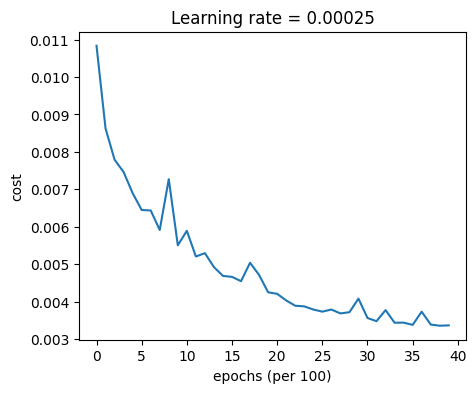

Train
Accuracy: 0.9327
Test
Accuracy: 0.5633


In [123]:
parameters = model(X = train_x,
                   Y = train_labels,
                   layers_dims = layers_dims,
                   optimizer = "adam",
                   num_epochs=4000,
                   learning_rate=0.001,
                   decay=schedule_lr_decay)

print("Train")
pred_train = predict(train_x, train_labels, parameters)

print("Test")
pred_test = predict(test_x, test_labels, parameters)

We can conclude that we have some strategies to try to improve our models. They won't necessarily work all the time, but they are possibilities to explore:

* Apply three different optimization methods to your models 
* Build mini-batches for your training set 
* Use learning rate decay scheduling to speed up your training